Reading data...
Successfully loaded data with 287829 rows and 48 columns
Dropping variables with many NAs...
Filtering data for years 2010-2015...
Years in data:
year
2010    26784
2011    28222
2012    28469
2013    28474
2014    28151
2015    27506
Name: count, dtype: int64
Adding missing year-company combinations...
Generating status_alive...
Creating sales metrics...
Calculating sales growth...
Creating age variable...
Creating fast growth target...
Number of firms with data in both 2012 and 2014: 17927
Growth threshold for top 25%: 0.4631594321277708
Number of fast-growing firms: 4356
Percentage of fast-growing firms: 25.00%


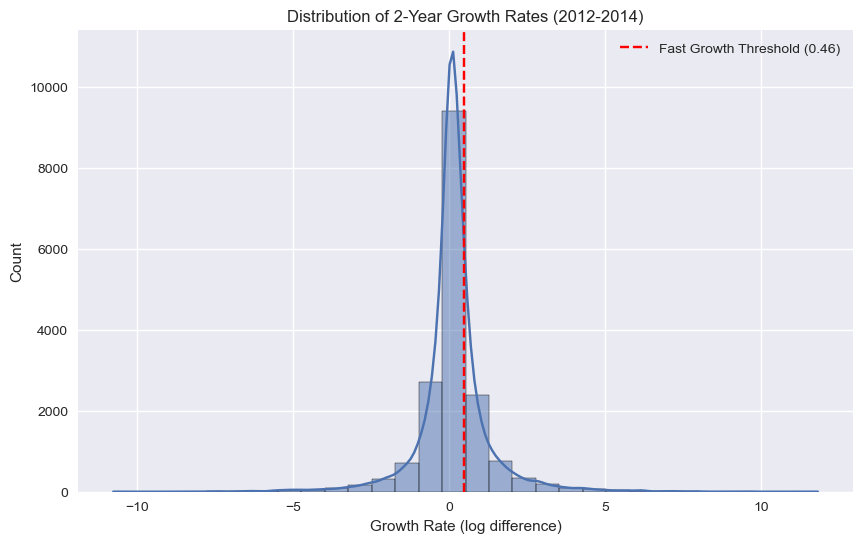

Created visualization of growth distribution
Creating sample for modeling...
Final sample size: 21723 firms
Feature engineering...
Industry distribution:
industry_group
Services         15372
Manufacturing     6351
Name: count, dtype: int64

# Exploratory Analysis for Fast Growth Prediction
## Running OLS regressions to understand relationships between variables

OLS Regression: Effect of Firm Size on Fast Growth
                            OLS Regression Results                            
Dep. Variable:            fast_growth   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     614.4
Date:                Tue, 08 Apr 2025   Prob (F-statistic):          3.15e-258
Time:                        00:35:51   Log-Likelihood:                -8936.2
No. Observations:               16780   AIC:                         1.788e+04
Df Residuals:                 

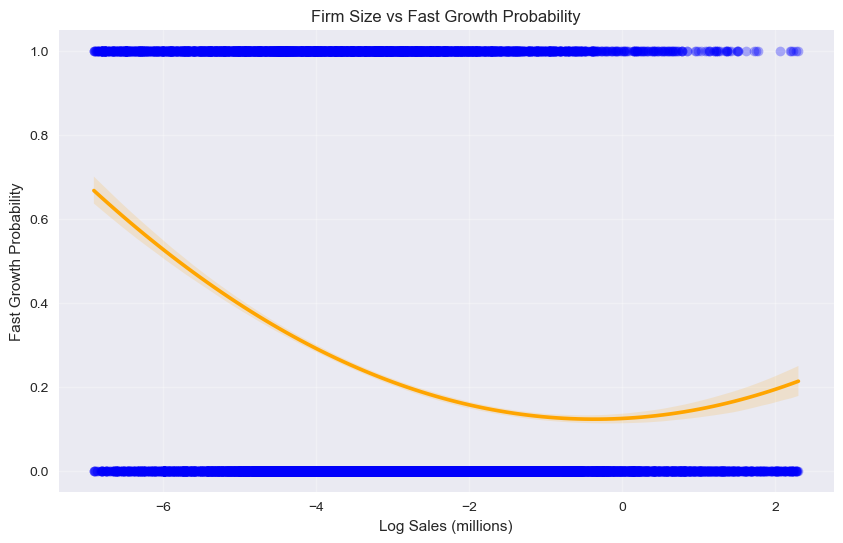


Created visualization of firm size vs fast growth


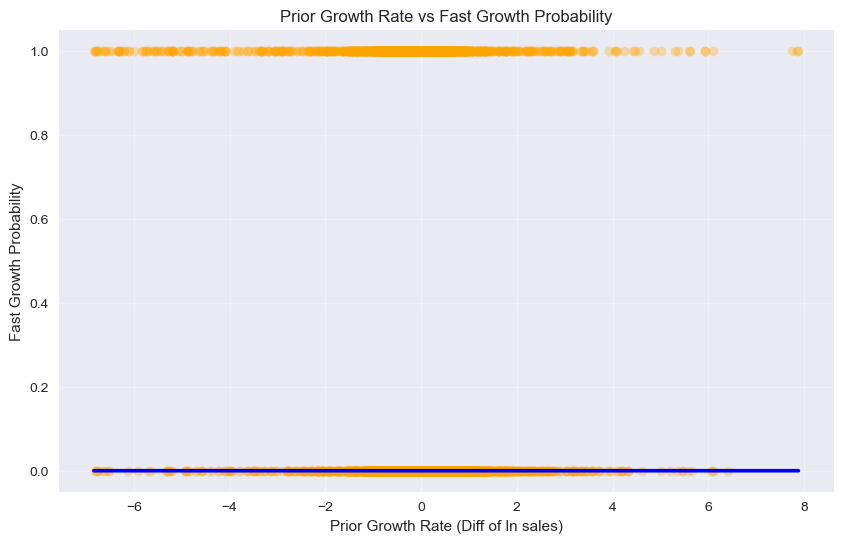

Created visualization of prior growth vs fast growth


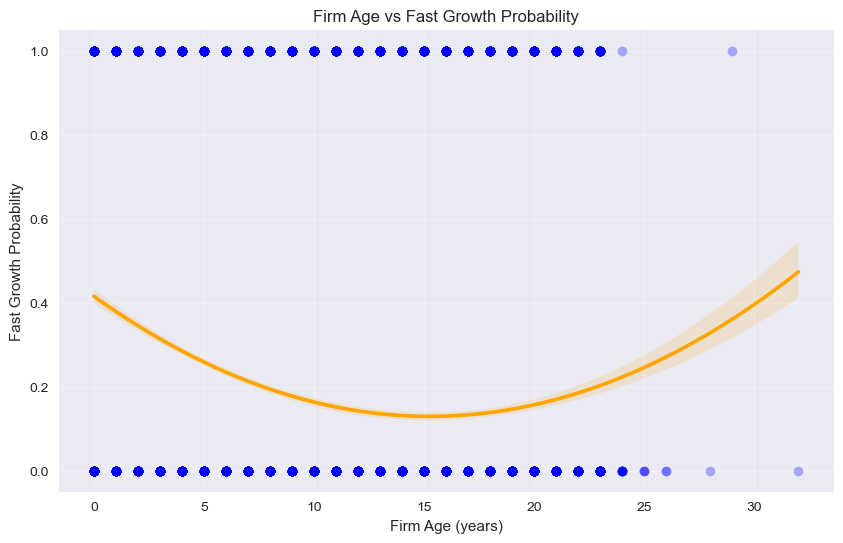

Created visualization of firm age vs fast growth


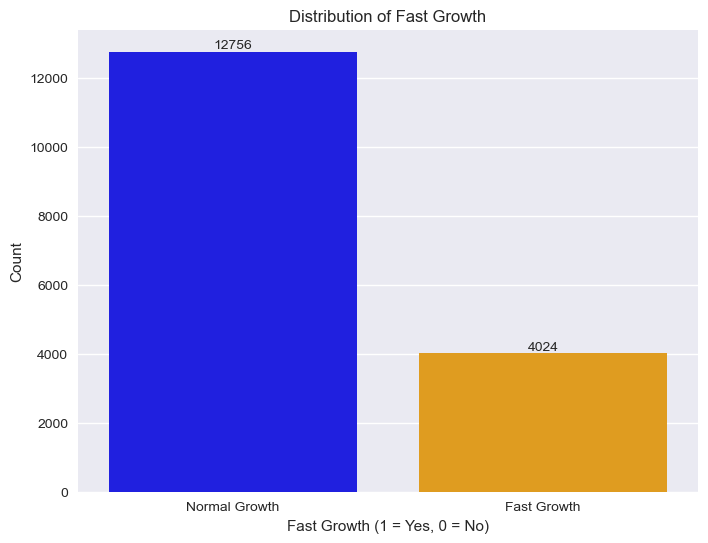

Created fast growth distribution bar chart


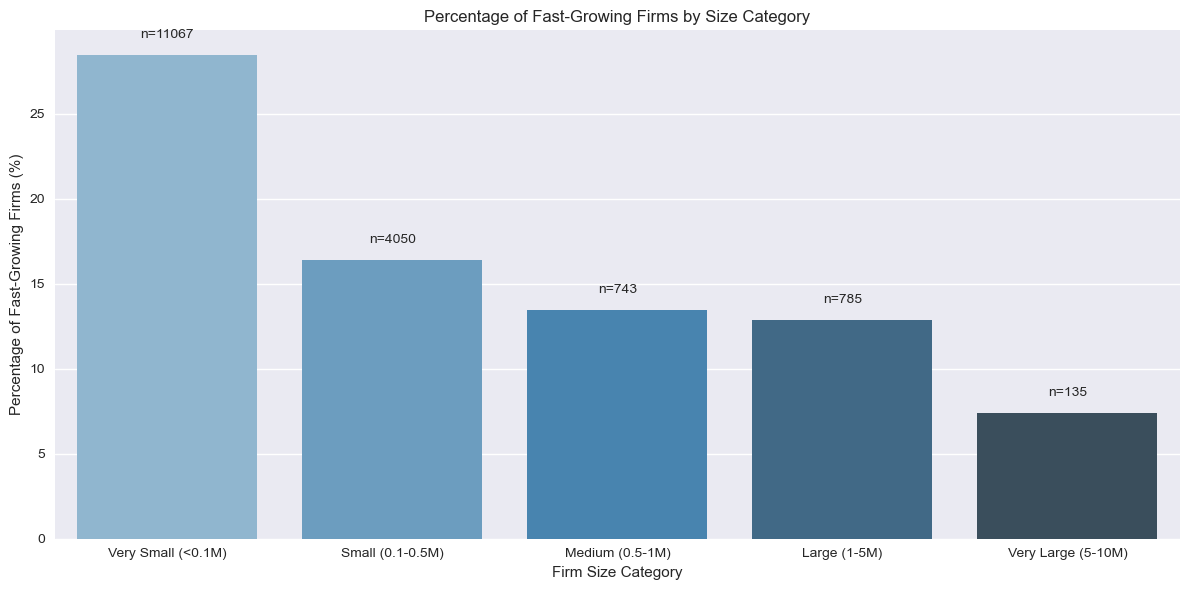

Created firm size analysis plot


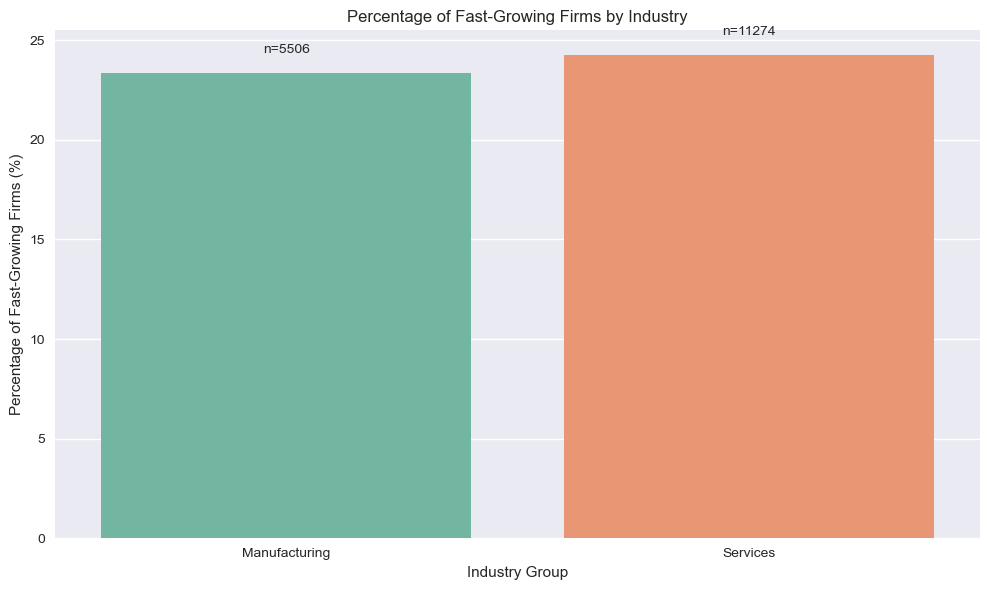

Created industry analysis plot
Saving prepared data to ./fast_growth_firms_clean.csv

Fast Growth Distribution:
   fast_growth  comp_id  percentage
0          0.0    12756    76.01907
1          1.0     4024    23.98093

Finished data preparation. Ready for modeling!


In [9]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

# Set up paths
# You will need to adjust these paths to match your environment
# Current script folder
path = os.getcwd()

# Define input and output paths
data_in = "."  # assuming the data is in the current directory
data_out = "."

# Import data
print("Reading data...")
csv_path = os.path.join(data_in, "cs_bisnode_panel.csv")

try:
    data = pd.read_csv(csv_path)
    print(f"Successfully loaded data with {data.shape[0]} rows and {data.shape[1]} columns")
except FileNotFoundError:
    print(f"File not found at {csv_path}")
    # Alternative approach if file not found locally
    print("Attempting to load from alternative source...")
    # You might want to add alternative loading logic here

# Drop variables with many NAs
print("Dropping variables with many NAs...")
data = data.drop(
    columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"]
)

# Filter data for the years we're interested in
print("Filtering data for years 2010-2015...")
data = data.query("year >= 2010 & year <= 2015")

# Check years in data
print("Years in data:")
print(data['year'].value_counts().sort_index())

# Add all missing year and comp_id combinations
print("Adding missing year-company combinations...")
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way to define it as NaN

# Generate status_alive; if sales larger than zero and not-NA, then firm is alive
print("Generating status_alive...")
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

# Create sales metrics
print("Creating sales metrics...")
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)  # handle negative sales
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)

# Add squared terms
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

# Calculate year-over-year growth
print("Calculating sales growth...")
data["sales_mil_log_lag1"] = data.groupby("comp_id")["sales_mil_log"].shift(1)
data["sales_mil_log_lag2"] = data.groupby("comp_id")["sales_mil_log"].shift(2)
data["growth_1y"] = data["sales_mil_log"] - data["sales_mil_log_lag1"]
data["growth_2y"] = data["sales_mil_log"] - data["sales_mil_log_lag2"]
data["growth_1y_sq"] = data["growth_1y"] ** 2

# Create age variable
print("Creating age variable...")
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["age2"] = data["age"] ** 2

data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)

# Replace growth for new firms with 0
data["growth_1y"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["growth_1y"])
)
data["growth_2y"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["growth_2y"])
)

# Define fast growth target (top 25% of growth in 2 years - from 2012 to 2014)
print("Creating fast growth target...")
# First filter to only firms with data in both 2012 and 2014
firms_with_both_years = data.query("year == 2012 & status_alive == 1")["comp_id"].tolist()
data_2014 = data.query("year == 2014 & status_alive == 1")
firms_with_both_years = list(set(firms_with_both_years) & set(data_2014["comp_id"].tolist()))

print(f"Number of firms with data in both 2012 and 2014: {len(firms_with_both_years)}")

# Get the growth data for these firms
growth_data = data.query("year == 2014 & comp_id in @firms_with_both_years").copy()
growth_data = growth_data[["comp_id", "growth_2y"]]
growth_data = growth_data.dropna(subset=["growth_2y"])

# Calculate threshold for top 25% growth
growth_threshold = growth_data["growth_2y"].quantile(0.75)
print(f"Growth threshold for top 25%: {growth_threshold}")

# Create fast growth indicator
growth_data["fast_growth"] = (growth_data["growth_2y"] >= growth_threshold).astype(int)
print(f"Number of fast-growing firms: {growth_data['fast_growth'].sum()}")
print(f"Percentage of fast-growing firms: {growth_data['fast_growth'].mean() * 100:.2f}%")

# Merge the fast growth indicator back to the main data
data = data.merge(growth_data[["comp_id", "fast_growth"]], on="comp_id", how="left")

# Create visualization of growth distribution
plt.figure(figsize=(10, 6))
sns.histplot(growth_data["growth_2y"], bins=30, kde=True)
plt.axvline(x=growth_threshold, color='red', linestyle='--', 
            label=f'Fast Growth Threshold ({growth_threshold:.2f})')
plt.title('Distribution of 2-Year Growth Rates (2012-2014)')
plt.xlabel('Growth Rate (log difference)')
plt.ylabel('Count')
plt.legend()
plt.savefig('growth_distribution.png', dpi=300, bbox_inches="tight")
plt.show()
plt.close()
print("Created visualization of growth distribution")

# Sample design - focus on firms in 2012
print("Creating sample for modeling...")
model_data = data.query("year == 2012 & status_alive == 1").copy()

# Look at firms below 10m euro revenues and above 1000 euros
model_data = model_data.query("sales_mil <= 10 & sales_mil >= 0.001")
print(f"Final sample size: {model_data.shape[0]} firms")

# Feature engineering
print("Feature engineering...")

# Change some industry category codes
model_data["ind2_cat"] = model_data["ind2"].copy()
model_data["ind2_cat"] = np.where(model_data["ind2"] > 56, 60, model_data["ind2_cat"])
model_data["ind2_cat"] = np.where(model_data["ind2"] < 26, 20, model_data["ind2_cat"])
model_data["ind2_cat"] = np.where(
    (model_data["ind2"] < 55) & (model_data["ind2"] > 35), 40, model_data["ind2_cat"]
)
model_data["ind2_cat"] = np.where(model_data["ind2"] == 31, 30, model_data["ind2_cat"])
model_data["ind2_cat"] = np.where(model_data["ind2"].isna(), 99, model_data["ind2_cat"])

# Industry groups - manufacturing and services
# Manufacturing: ind2 < 45, Services: ind2 >= 45
model_data["industry_group"] = np.where(model_data["ind2"] < 45, "Manufacturing", "Services")
print("Industry distribution:")
print(model_data["industry_group"].value_counts())

# Firm characteristics
model_data["foreign_management"] = np.where(
    model_data["foreign"] >= 0.5, 1, np.where(model_data["foreign"].isna(), np.nan, 0)
)
model_data["gender_m"] = model_data["gender"].astype("category")
model_data["m_region_loc"] = model_data["region_m"].astype("category")

# CEO age
model_data["ceo_age"] = model_data["year"] - model_data["birth_year"]
model_data["ceo_age"] = np.where(model_data["ceo_age"] < 25, 25, model_data["ceo_age"])
model_data["ceo_age"] = np.where(model_data["ceo_age"] > 75, 75, model_data["ceo_age"])
model_data["ceo_age"] = np.where(
    model_data["ceo_age"].isna(), model_data["ceo_age"].mean(), model_data["ceo_age"]
)
model_data["ceo_young"] = (model_data["ceo_age"] < 40).astype(int)

# Create category type variables
model_data["urban_m"] = model_data["urban_m"].astype("category")
model_data["ind2_cat"] = model_data["ind2_cat"].astype("category")
model_data["fast_growth_f"] = model_data["fast_growth"].astype("category")
model_data["fast_growth_f"] = model_data["fast_growth_f"].cat.rename_categories(["normal_growth", "fast_growth"])

# OLS regression analysis
print("\n# Exploratory Analysis for Fast Growth Prediction")
print("## Running OLS regressions to understand relationships between variables\n")

# Size effect on fast growth
try:
    ols_sales = smf.ols("fast_growth ~ sales_mil_log + sales_mil_log_sq", data=model_data).fit()
    print("OLS Regression: Effect of Firm Size on Fast Growth")
    print(ols_sales.summary())
except Exception as e:
    print(f"Could not run size OLS regression: {e}")

# Growth effect on future fast growth
try:
    ols_growth = smf.ols("fast_growth ~ growth_1y + growth_1y_sq", data=model_data).fit()
    print("\nOLS Regression: Effect of Prior Growth on Fast Growth")
    print(ols_growth.summary())
except Exception as e:
    print(f"Could not run growth OLS regression: {e}")

# Age effect on fast growth
try:
    ols_age = smf.ols("fast_growth ~ age + age2", data=model_data).fit()
    print("\nOLS Regression: Effect of Firm Age on Fast Growth")
    print(ols_age.summary())
except Exception as e:
    print(f"Could not run age OLS regression: {e}")

# Create key visualizations
try:
    # 1. Size vs Fast Growth
    plt.figure(figsize=(10, 6))
    sns.regplot(x="sales_mil_log", y="fast_growth", data=model_data, 
                scatter_kws={'alpha':0.3, 'color':'blue'}, 
                line_kws={'color':'orange'},
                order=2)
    plt.title('Firm Size vs Fast Growth Probability')
    plt.xlabel('Log Sales (millions)')
    plt.ylabel('Fast Growth Probability')
    plt.grid(True, alpha=0.3)
    plt.savefig("size_vs_fast_growth.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    print("\nCreated visualization of firm size vs fast growth")
    
    # 2. Prior Growth vs Fast Growth
    plt.figure(figsize=(10, 6))
    sns.regplot(x="growth_1y", y="fast_growth", data=model_data, 
                scatter_kws={'alpha':0.3, 'color':'orange'}, 
                line_kws={'color':'blue'},
                lowess=True)
    plt.title('Prior Growth Rate vs Fast Growth Probability')
    plt.xlabel('Prior Growth Rate (Diff of ln sales)')
    plt.ylabel('Fast Growth Probability')
    plt.grid(True, alpha=0.3)
    plt.savefig("prior_growth_vs_fast_growth.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    print("Created visualization of prior growth vs fast growth")
    
    # 3. Age vs Fast Growth
    plt.figure(figsize=(10, 6))
    sns.regplot(x="age", y="fast_growth", data=model_data, 
                scatter_kws={'alpha':0.3, 'color':'blue'}, 
                line_kws={'color':'orange'},
                order=2)
    plt.title('Firm Age vs Fast Growth Probability')
    plt.xlabel('Firm Age (years)')
    plt.ylabel('Fast Growth Probability')
    plt.grid(True, alpha=0.3)
    plt.savefig("age_vs_fast_growth.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    print("Created visualization of firm age vs fast growth")
    
    # 4. Fast Growth Distribution
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x="fast_growth", data=model_data, palette=['blue', 'orange'])
    # Add count labels on top of each bar
    for i in ax.containers:
        ax.bar_label(i)
    plt.title('Distribution of Fast Growth')
    plt.xlabel('Fast Growth (1 = Yes, 0 = No)')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Normal Growth', 'Fast Growth'])
    plt.savefig("fast_growth_distribution_bar.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    print("Created fast growth distribution bar chart")
    
    # 5. Firm Size Category Analysis
    model_data['size_category'] = pd.cut(
        model_data['sales_mil'],
        bins=[0, 0.1, 0.5, 1, 5, 10],
        labels=['Very Small (<0.1M)', 'Small (0.1-0.5M)', 'Medium (0.5-1M)', 'Large (1-5M)', 'Very Large (5-10M)']
    )
    
    size_growth = model_data.groupby('size_category')['fast_growth'].agg(['mean', 'count']).reset_index()
    size_growth['mean'] = size_growth['mean'] * 100  # Convert to percentage
    
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='size_category', y='mean', data=size_growth, palette='Blues_d')
    
    # Add count labels on top of each bar
    for i, row in enumerate(size_growth.itertuples()):
        ax.text(i, row.mean + 1, f'n={row.count}', ha='center')
        
    plt.title('Percentage of Fast-Growing Firms by Size Category')
    plt.xlabel('Firm Size Category')
    plt.ylabel('Percentage of Fast-Growing Firms (%)')
    plt.tight_layout()
    plt.savefig('size_fast_growth_rates.png', dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    print("Created firm size analysis plot")
    
    # 6. Industry Analysis
    industry_growth = model_data.groupby('industry_group')['fast_growth'].agg(['mean', 'count']).reset_index()
    industry_growth['mean'] = industry_growth['mean'] * 100  # Convert to percentage
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='industry_group', y='mean', data=industry_growth, palette='Set2')
    
    # Add count labels on top of each bar
    for i, row in enumerate(industry_growth.itertuples()):
        ax.text(i, row.mean + 1, f'n={row.count}', ha='center')
        
    plt.title('Percentage of Fast-Growing Firms by Industry')
    plt.xlabel('Industry Group')
    plt.ylabel('Percentage of Fast-Growing Firms (%)')
    plt.tight_layout()
    plt.savefig('industry_fast_growth_rates.png', dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    print("Created industry analysis plot")
    
except Exception as e:
    print(f"Could not create visualizations: {e}")

# Save the prepared data
output_path = os.path.join(data_out, "fast_growth_firms_clean.csv")
print(f"Saving prepared data to {output_path}")
model_data.to_csv(output_path, index=False)

# Final statistics about the target variable
fast_growth_summary = model_data.groupby("fast_growth")["comp_id"].count().reset_index()
fast_growth_summary["percentage"] = 100 * fast_growth_summary["comp_id"] / fast_growth_summary["comp_id"].sum()
print("\nFast Growth Distribution:")
print(fast_growth_summary)

print("\nFinished data preparation. Ready for modeling!")

Loading prepared data...
Loaded data with 21723 rows and 66 columns

Target variable distribution:
fast_growth
0.0    12756
1.0     4024
Name: count, dtype: int64
Proportion fast growth: 0.2398
Checking for NaN values in target variable...
NaN values in fast_growth: 4943
Data shape after dropping NaN targets: (16780, 66)
Checking for NaN values in features...
Columns with NaN values: age                   1286
age2                  1286
growth_1y             1027
growth_1y_sq          1215
foreign               1286
new                    938
foreign_management    1286
dtype: int64
Filled any remaining NaN values in features
Feature matrix shape: (16780, 28)
Training set size: 13424
Test set size: 3356


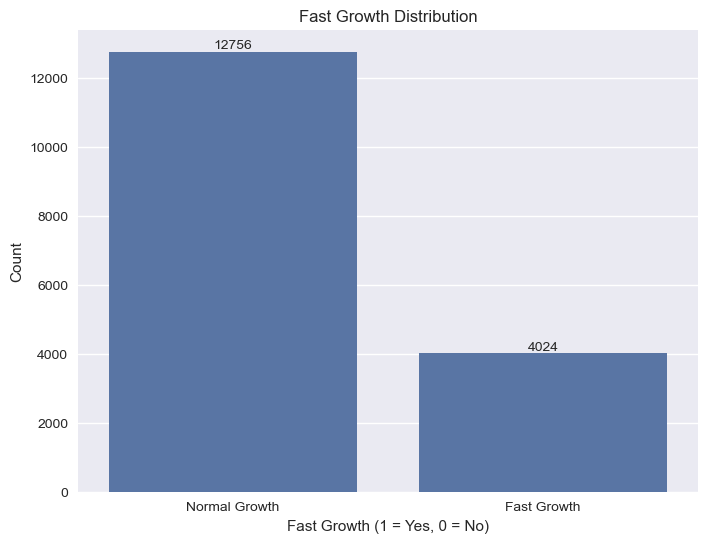

Created visualization of class distribution

----- Model 1: Logistic Regression with basic features -----

Logistic Regression - Cross-Validation Results (Mean ± Std):
Accuracy  : 0.7829 ± 0.0037
Precision : 0.6394 ± 0.0185
Recall    : 0.2168 ± 0.0156
F1        : 0.3237 ± 0.0191
Roc_auc   : 0.7127 ± 0.0112

----- Model 2: Random Forest with basic features -----

Random Forest - Cross-Validation Results (Mean ± Std):
Accuracy  : 0.7882 ± 0.0069
Precision : 0.6511 ± 0.0392
Recall    : 0.2523 ± 0.0161
F1        : 0.3635 ± 0.0216
Roc_auc   : 0.7344 ± 0.0126

Top 10 most important features for Random Forest:
               feature  importance
5         growth_1y_sq    0.212271
1     sales_mil_log_sq    0.159428
0        sales_mil_log    0.149950
4            growth_1y    0.080255
2                  age    0.078534
3                 age2    0.074264
8                  new    0.058799
6              ceo_age    0.053526
7              foreign    0.012965
10  foreign_management    0.011540


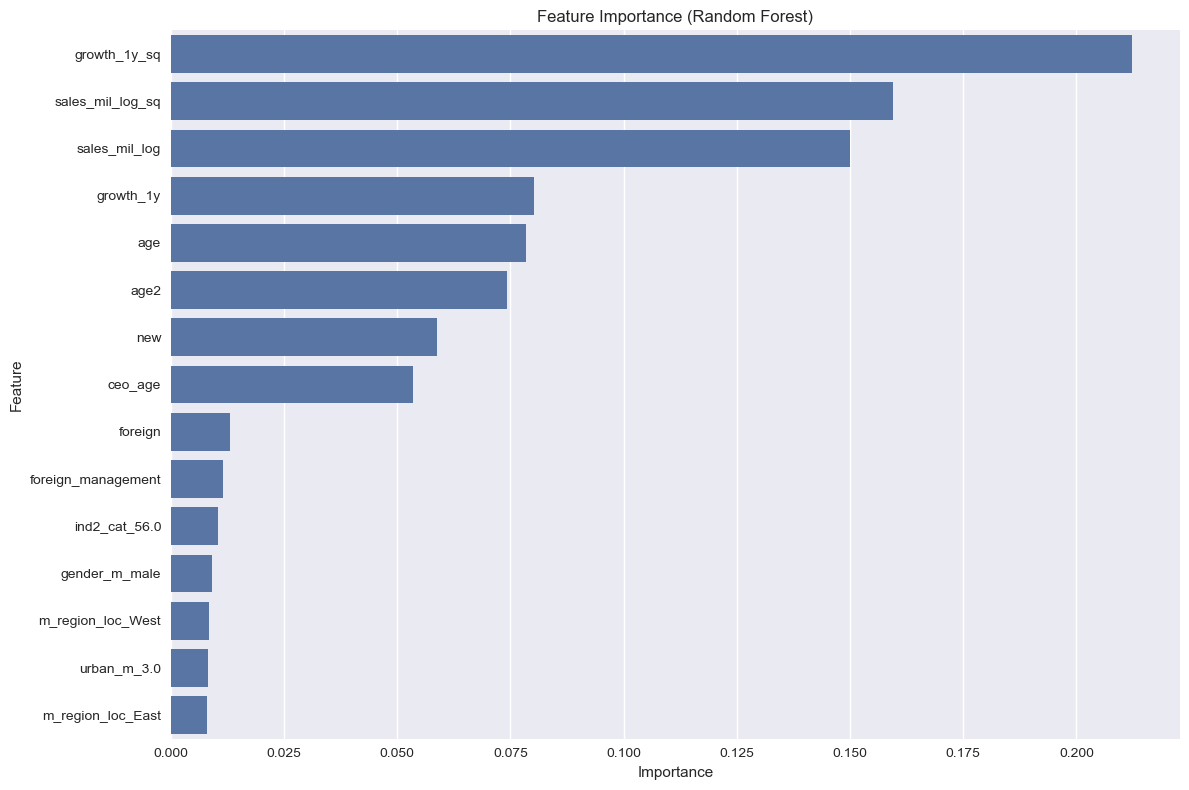


----- Model 3: Gradient Boosting Classifier -----

Gradient Boosting - Cross-Validation Results (Mean ± Std):
Accuracy  : 0.7820 ± 0.0089
Precision : 0.6010 ± 0.0416
Recall    : 0.2709 ± 0.0210
F1        : 0.3733 ± 0.0273
Roc_auc   : 0.7299 ± 0.0122

----- Model Comparison (Cross-Validation) -----
Logistic Regression: ROC AUC = 0.7127 ± 0.0112
Random Forest: ROC AUC = 0.7344 ± 0.0126
Gradient Boosting: ROC AUC = 0.7299 ± 0.0122

----- Business Problem and Loss Function -----
For the fast growth prediction problem:
False Positive (FP): Predicting a firm will have fast growth when it doesn't
False Negative (FN): Missing a firm that will have fast growth
Let's assume the following costs:
- FP Cost: $1 (opportunity cost of resources invested)
- FN Cost: $5 (missed opportunity for high return on investment)

----- Finding Optimal Classification Thresholds -----

Logistic Regression:


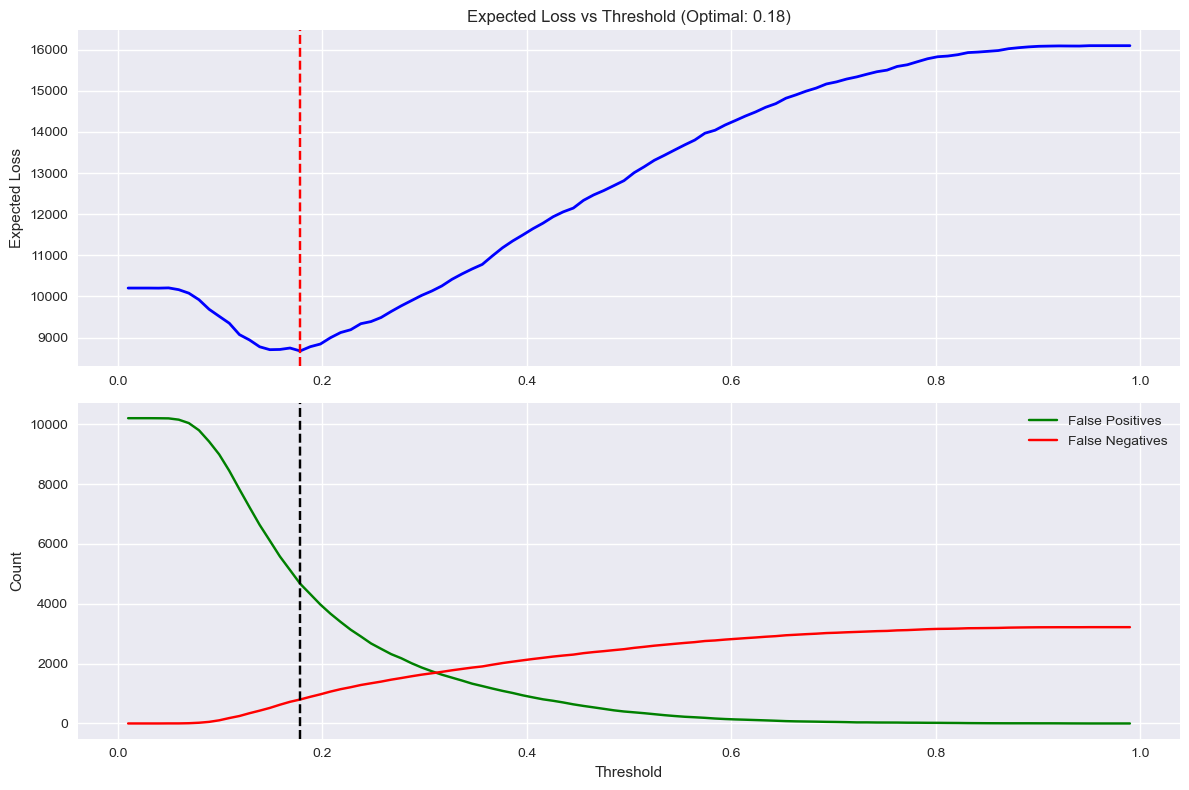

Optimal threshold: 0.1783
Minimum expected loss: $8677
Optimal threshold: 0.1783
Accuracy: 0.5909
Precision: 0.3375
Recall: 0.7329
F1 Score: 0.4622
ROC AUC: 0.7027
Expected Loss: $2233
Confusion Matrix:
[[1393 1158]
 [ 215  590]]


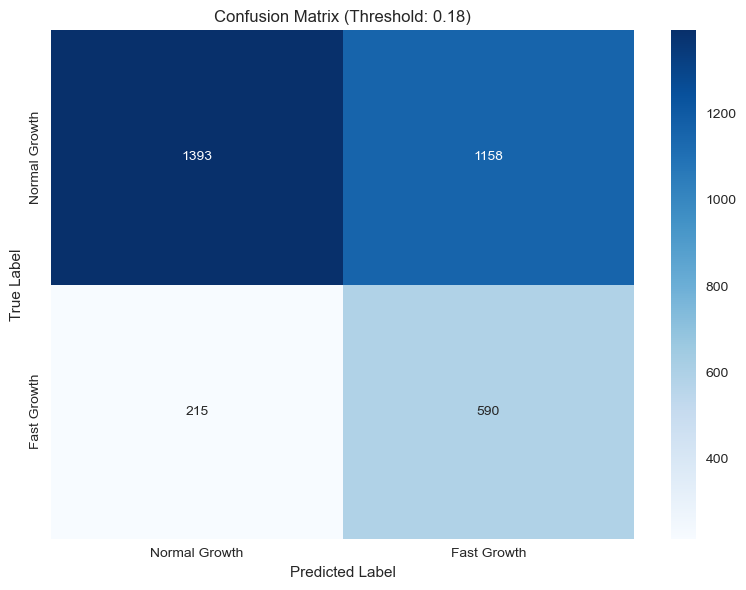


Random Forest:


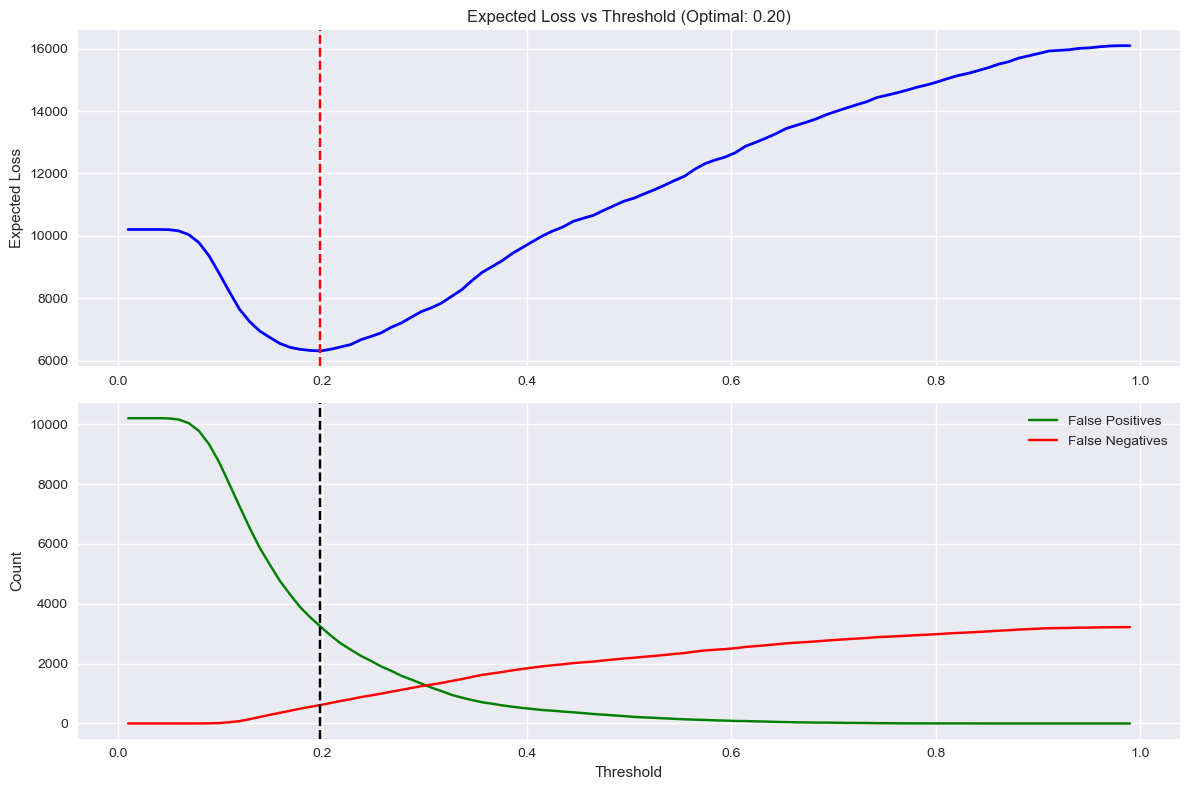

Optimal threshold: 0.1981
Minimum expected loss: $6312
Optimal threshold: 0.1981
Accuracy: 0.6409
Precision: 0.3649
Recall: 0.6708
F1 Score: 0.4726
ROC AUC: 0.7284
Expected Loss: $2265
Confusion Matrix:
[[1611  940]
 [ 265  540]]


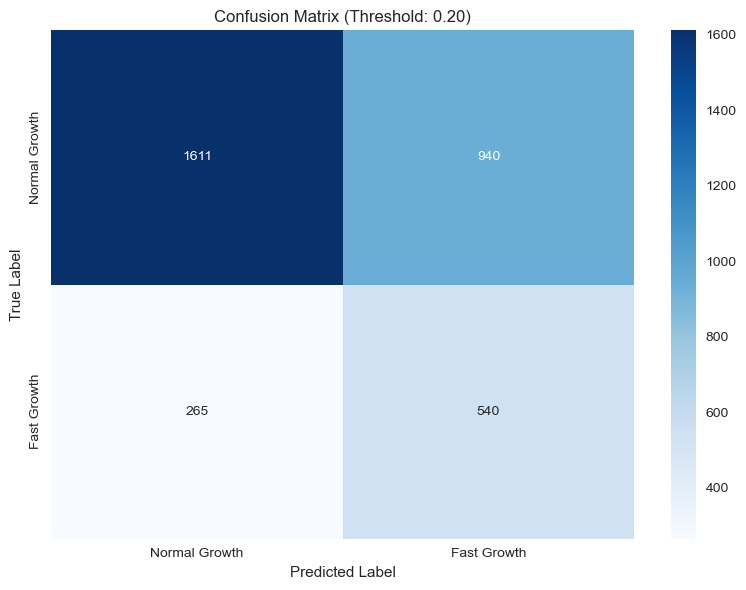


Gradient Boosting:


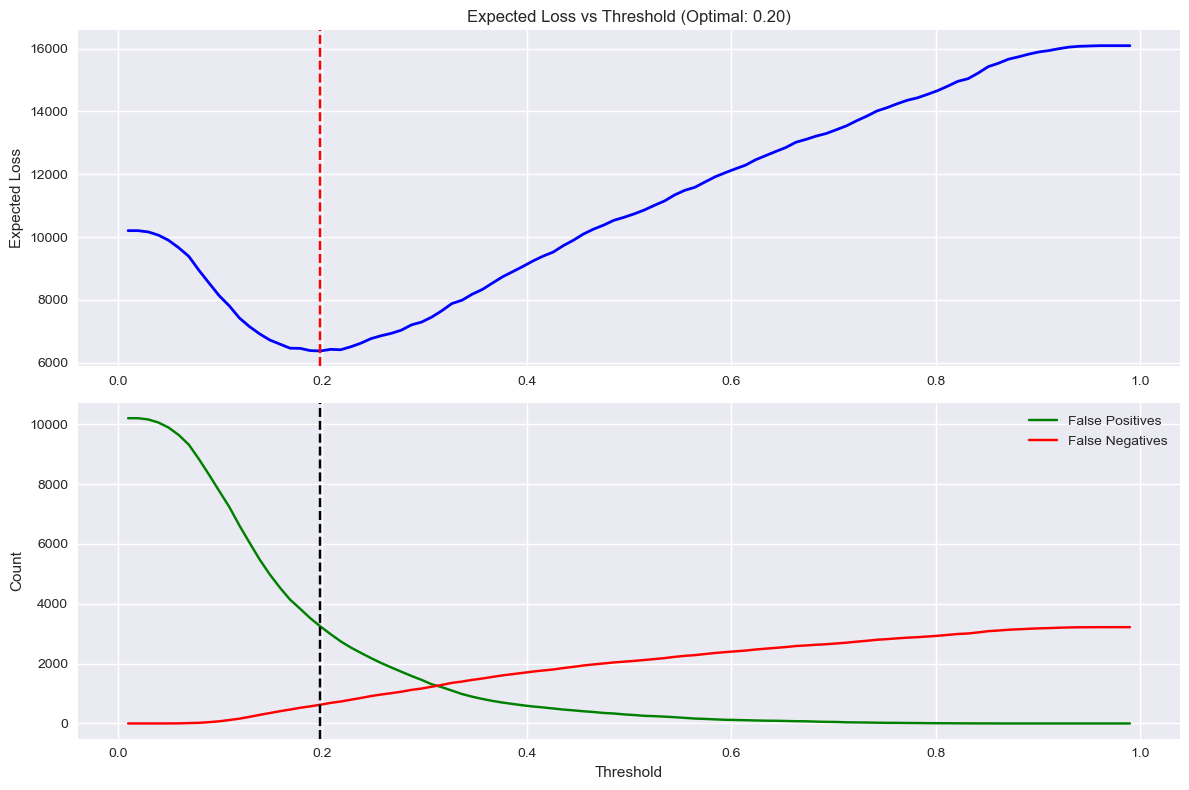

Optimal threshold: 0.1981
Minimum expected loss: $6373
Optimal threshold: 0.1981
Accuracy: 0.6445
Precision: 0.3684
Recall: 0.6745
F1 Score: 0.4765
ROC AUC: 0.7292
Expected Loss: $2241
Confusion Matrix:
[[1620  931]
 [ 262  543]]


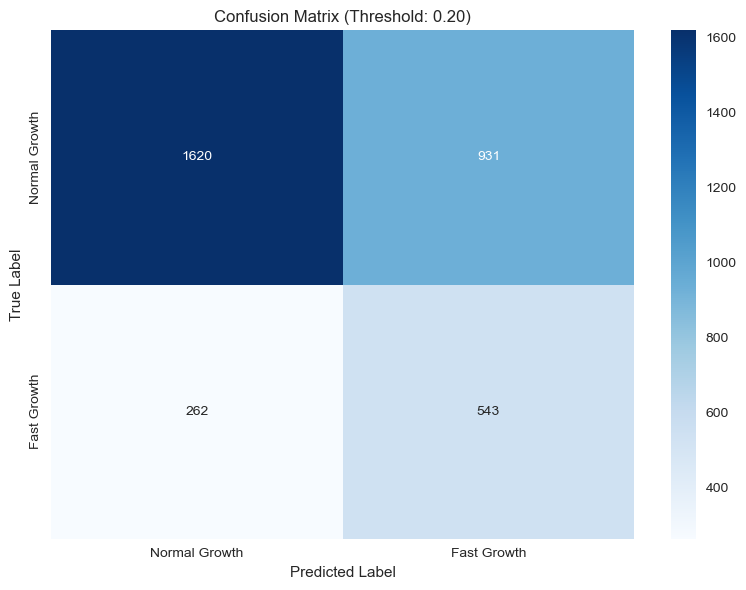


----- Model Comparison (Expected Loss) -----
Logistic Regression: $2233
Random Forest: $2265
Gradient Boosting: $2241

Best model based on expected loss: Logistic Regression


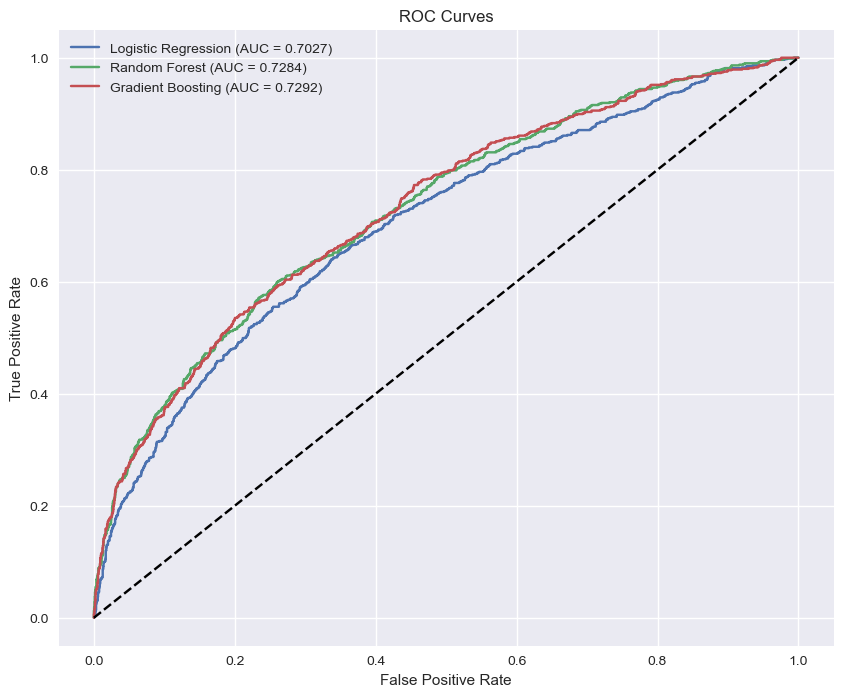

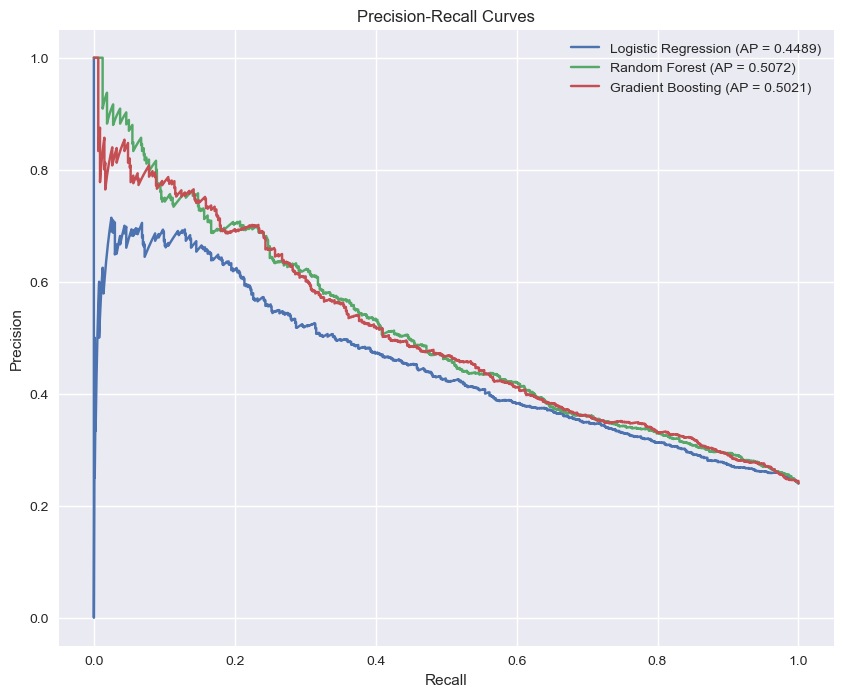


----- Task 2: Analysis by Industry Group -----
Manufacturing firms: 5506
Services firms: 11274

Using Logistic Regression for industry analysis

Manufacturing Industry:


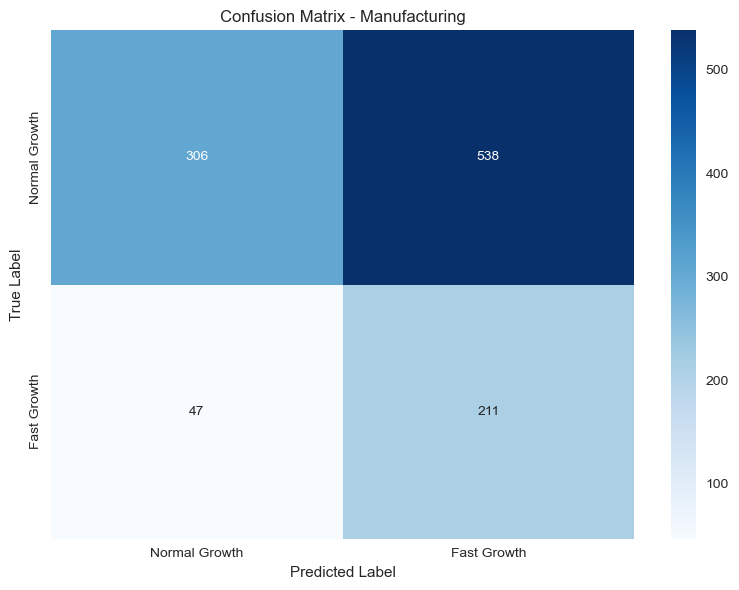

Optimal threshold: 0.1700
Expected loss: $773
Accuracy: 0.4691
Precision: 0.2817
Recall: 0.8178
F1 Score: 0.4191
ROC AUC: 0.6730

Services Industry:


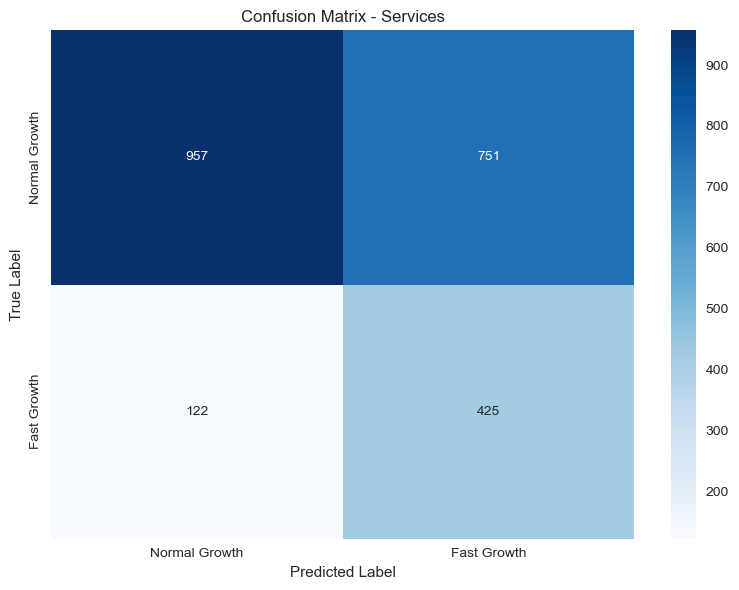

Optimal threshold: 0.1700
Expected loss: $1361
Accuracy: 0.6129
Precision: 0.3614
Recall: 0.7770
F1 Score: 0.4933
ROC AUC: 0.7424

----- Industry Comparison -----
Manufacturing AUC: 0.6730, Expected Loss: $773
Services AUC: 0.7424, Expected Loss: $1361


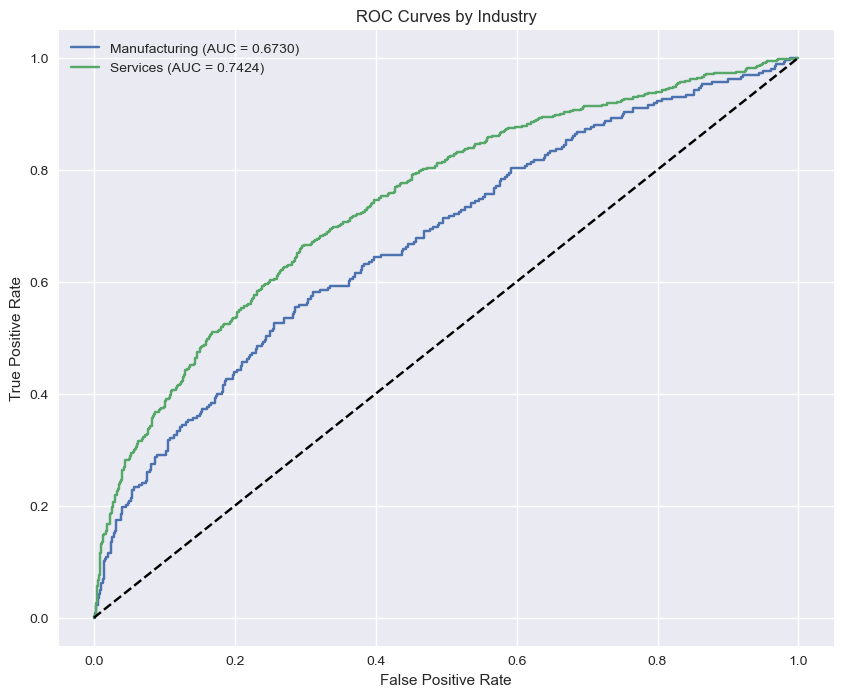

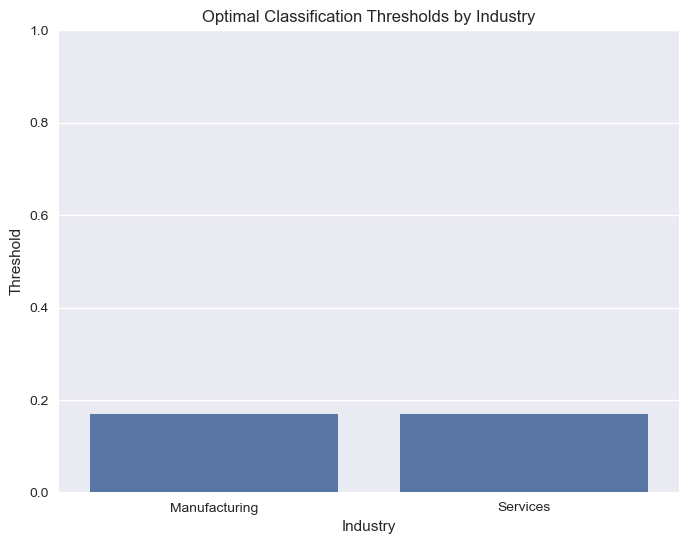


Analysis complete! Results saved to fast_growth_prediction_summary.txt


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.pipeline import Pipeline
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings("ignore")

# Set up paths
data_dir = "."  # Change this to your data directory
output_dir = "."  # Change this to your output directory

# Load the prepared data
print("Loading prepared data...")
data_path = os.path.join(data_dir, "fast_growth_firms_clean.csv")
try:
    data = pd.read_csv(data_path)
    print(f"Loaded data with {data.shape[0]} rows and {data.shape[1]} columns")
except FileNotFoundError:
    print(f"File not found at {data_path}")
    raise

# Print basic statistics about the target variable
print("\nTarget variable distribution:")
print(data["fast_growth"].value_counts())
print(f"Proportion fast growth: {data['fast_growth'].mean():.4f}")

# Define features for model building
# Basic numerical features
numerical_features = [
    "sales_mil_log", "sales_mil_log_sq",
    "age", "age2", 
    "growth_1y", "growth_1y_sq",
    "ceo_age",
    "foreign"
]

# Categorical features to one-hot encode
categorical_features = [
    "ind2_cat", "urban_m", "gender_m", "m_region_loc",
]

# Binary flags
binary_features = [
    "new", "ceo_young", "foreign_management"
]

# Make sure we have no NaN values in the target variable
print("Checking for NaN values in target variable...")
print(f"NaN values in fast_growth: {data['fast_growth'].isna().sum()}")

# Drop rows with NaN in the target variable
data_model = data.dropna(subset=["fast_growth"])
print(f"Data shape after dropping NaN targets: {data_model.shape}")

# Split into X (features) and y (target)
X = data_model[numerical_features + categorical_features + binary_features]
y = data_model["fast_growth"].astype(int)  # Ensure target is integer type

# Create dummy variables for categorical features
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Check for any remaining NaN values in features
print("Checking for NaN values in features...")
nan_counts = X.isna().sum()
print(f"Columns with NaN values: {nan_counts[nan_counts > 0]}")

# Fill any remaining NaN values with column means for numeric features
X = X.fillna(X.mean())
print("Filled any remaining NaN values in features")

# Print the shape of the feature matrix
print(f"Feature matrix shape: {X.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Create a visualization of the class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='fast_growth', data=data_model)
# Add count labels on top of each bar
for i in ax.containers:
    ax.bar_label(i)
plt.title('Fast Growth Distribution')
plt.xlabel('Fast Growth (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Normal Growth', 'Fast Growth'])
plt.savefig('fast_growth_distribution.png', dpi=300, bbox_inches="tight")
plt.show()
plt.close()
print("Created visualization of class distribution")

# Create a function to evaluate models
def evaluate_model(model, X, y, cv=5, scoring=None, model_name="Model"):
    """
    Evaluate a model using cross-validation and return metrics.
    """
    if scoring is None:
        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    
    # Cross-validation scores
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)
    
    # Print mean and standard deviation of each metric
    print(f"\n{model_name} - Cross-Validation Results (Mean ± Std):")
    for metric in scoring:
        score_key = f'test_{metric}'
        if score_key in cv_results:
            mean_score = cv_results[score_key].mean()
            std_score = cv_results[score_key].std()
            print(f"{metric.capitalize():10}: {mean_score:.4f} ± {std_score:.4f}")
    
    return cv_results

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", figsize=(8, 6), save_path=None):
    """
    Plot a confusion matrix for binary classification.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal Growth', 'Fast Growth'],
                yticklabels=['Normal Growth', 'Fast Growth'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    return cm

def calculate_expected_loss(y_true, y_pred, fp_cost=1, fn_cost=5):
    """
    Calculate expected loss based on false positive and false negative costs.
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    total_fp_cost = fp * fp_cost
    total_fn_cost = fn * fn_cost
    total_cost = total_fp_cost + total_fn_cost
    
    print(f"False Positives: {fp} x ${fp_cost} = ${total_fp_cost}")
    print(f"False Negatives: {fn} x ${fn_cost} = ${total_fn_cost}")
    print(f"Total Cost: ${total_cost}")
    
    return total_cost, total_fp_cost, total_fn_cost

def find_optimal_threshold(model, X, y, fp_cost=1, fn_cost=5, n_thresholds=100):
    """
    Find the optimal threshold for classification based on the specified cost function.
    """
    y_proba = model.predict_proba(X)[:, 1]
    
    thresholds = np.linspace(0.01, 0.99, n_thresholds)
    costs = []
    fp_counts = []
    fn_counts = []
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        cm = confusion_matrix(y, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        cost = fp * fp_cost + fn * fn_cost
        costs.append(cost)
        fp_counts.append(fp)
        fn_counts.append(fn)
    
    # Find optimal threshold
    min_cost_idx = np.argmin(costs)
    best_threshold = thresholds[min_cost_idx]
    min_cost = costs[min_cost_idx]
    
    # Plot cost vs threshold
    plt.figure(figsize=(12, 8))
    
    # Plot cost curve
    plt.subplot(2, 1, 1)
    plt.plot(thresholds, costs, 'b-', linewidth=2)
    plt.axvline(x=best_threshold, color='r', linestyle='--')
    plt.title(f'Expected Loss vs Threshold (Optimal: {best_threshold:.2f})')
    plt.ylabel('Expected Loss')
    plt.grid(True)
    
    # Plot FP and FN counts
    plt.subplot(2, 1, 2)
    plt.plot(thresholds, fp_counts, 'g-', label='False Positives')
    plt.plot(thresholds, fn_counts, 'r-', label='False Negatives')
    plt.axvline(x=best_threshold, color='k', linestyle='--')
    plt.xlabel('Threshold')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('threshold_optimization.png', dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    
    print(f"Optimal threshold: {best_threshold:.4f}")
    print(f"Minimum expected loss: ${min_cost}")
    
    return best_threshold, min_cost

# Function to evaluate a model with optimal threshold
def evaluate_with_optimal_threshold(model, X_train, y_train, X_test, y_test, fp_cost=1, fn_cost=5):
    """
    Train a model, find optimal threshold, and evaluate performance.
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Get predicted probabilities on the test set
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Find optimal threshold
    best_threshold, _ = find_optimal_threshold(model, X_train, y_train, fp_cost, fn_cost)
    
    # Apply the optimal threshold
    y_pred_optimal = (y_proba >= best_threshold).astype(int)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred_optimal)
    prec = precision_score(y_test, y_pred_optimal)
    rec = recall_score(y_test, y_pred_optimal)
    f1 = f1_score(y_test, y_pred_optimal)
    auc = roc_auc_score(y_test, y_proba)
    
    # Calculate expected loss
    cm = confusion_matrix(y_test, y_pred_optimal)
    tn, fp, fn, tp = cm.ravel()
    total_cost = fp * fp_cost + fn * fn_cost
    
    # Print results
    print(f"Optimal threshold: {best_threshold:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print(f"Expected Loss: ${total_cost}")
    print("Confusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plot_confusion_matrix(
        y_test, y_pred_optimal, 
        title=f"Confusion Matrix (Threshold: {best_threshold:.2f})",
        save_path=f"confusion_matrix_{model.__class__.__name__}.png"
    )
    
    return {
        'model': model,
        'threshold': best_threshold,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': auc,
        'cost': total_cost,
        'confusion_matrix': cm,
        'y_pred': y_pred_optimal,
        'y_proba': y_proba
    }

# Model 1: Logistic Regression with basic features
print("\n----- Model 1: Logistic Regression with basic features -----")
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Evaluate the model with cross-validation
logistic_results = evaluate_model(
    logistic_pipeline, X_train, y_train, cv=5, 
    model_name="Logistic Regression"
)

# Model 2: Random Forest with basic features
print("\n----- Model 2: Random Forest with basic features -----")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    min_samples_split=10,
    random_state=42
)

# Evaluate the model with cross-validation
rf_results = evaluate_model(
    rf_model, X_train, y_train, cv=5,
    model_name="Random Forest"
)

# Train the Random Forest model for feature importance
rf_model.fit(X_train, y_train)

# Feature importance for Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 most important features for Random Forest:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importance_rf.png', dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# Model 3: Gradient Boosting Classifier
print("\n----- Model 3: Gradient Boosting Classifier -----")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Evaluate the model with cross-validation
gb_results = evaluate_model(
    gb_model, X_train, y_train, cv=5,
    model_name="Gradient Boosting"
)

# Compare models using ROC AUC as the main metric
models_cv_results = {
    'Logistic Regression': logistic_results,
    'Random Forest': rf_results,
    'Gradient Boosting': gb_results
}

print("\n----- Model Comparison (Cross-Validation) -----")
for name, results in models_cv_results.items():
    mean_roc_auc = results['test_roc_auc'].mean()
    std_roc_auc = results['test_roc_auc'].std()
    print(f"{name}: ROC AUC = {mean_roc_auc:.4f} ± {std_roc_auc:.4f}")

# Define the business problem and loss function
print("\n----- Business Problem and Loss Function -----")
print("For the fast growth prediction problem:")
print("False Positive (FP): Predicting a firm will have fast growth when it doesn't")
print("False Negative (FN): Missing a firm that will have fast growth")
print("Let's assume the following costs:")
print("- FP Cost: $1 (opportunity cost of resources invested)")
print("- FN Cost: $5 (missed opportunity for high return on investment)")

# Define loss function costs
fp_cost = 1  # Cost of false positive
fn_cost = 5  # Cost of false negative

# Find optimal thresholds for each model based on the loss function
print("\n----- Finding Optimal Classification Thresholds -----")

# 1. Logistic Regression
print("\nLogistic Regression:")
logistic_eval = evaluate_with_optimal_threshold(
    logistic_pipeline, X_train, y_train, X_test, y_test, fp_cost, fn_cost
)

# 2. Random Forest
print("\nRandom Forest:")
rf_eval = evaluate_with_optimal_threshold(
    rf_model, X_train, y_train, X_test, y_test, fp_cost, fn_cost
)

# 3. Gradient Boosting
print("\nGradient Boosting:")
gb_eval = evaluate_with_optimal_threshold(
    gb_model, X_train, y_train, X_test, y_test, fp_cost, fn_cost
)

# Compare models based on expected loss
model_evaluations = {
    'Logistic Regression': logistic_eval,
    'Random Forest': rf_eval,
    'Gradient Boosting': gb_eval
}

print("\n----- Model Comparison (Expected Loss) -----")
for name, eval_results in model_evaluations.items():
    print(f"{name}: ${eval_results['cost']}")

# Select the best model based on expected loss
best_model_name = min(model_evaluations.items(), key=lambda x: x[1]['cost'])[0]
print(f"\nBest model based on expected loss: {best_model_name}")

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
# Logistic Regression
fpr, tpr, _ = roc_curve(y_test, logistic_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {logistic_eval["auc"]:.4f})')

# Random Forest
fpr, tpr, _ = roc_curve(y_test, rf_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {rf_eval["auc"]:.4f})')

# Gradient Boosting
fpr, tpr, _ = roc_curve(y_test, gb_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {gb_eval["auc"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# Add precision-recall curves
plt.figure(figsize=(10, 8))

# Logistic Regression
precision, recall, _ = precision_recall_curve(y_test, logistic_eval['y_proba'])
avg_precision = average_precision_score(y_test, logistic_eval['y_proba'])
plt.plot(recall, precision, label=f'Logistic Regression (AP = {avg_precision:.4f})')

# Random Forest
precision, recall, _ = precision_recall_curve(y_test, rf_eval['y_proba'])
avg_precision = average_precision_score(y_test, rf_eval['y_proba'])
plt.plot(recall, precision, label=f'Random Forest (AP = {avg_precision:.4f})')

# Gradient Boosting
precision, recall, _ = precision_recall_curve(y_test, gb_eval['y_proba'])
avg_precision = average_precision_score(y_test, gb_eval['y_proba'])
plt.plot(recall, precision, label=f'Gradient Boosting (AP = {avg_precision:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# --------------------------------
# Task 2: Separate analysis for Manufacturing and Services
# --------------------------------
print("\n----- Task 2: Analysis by Industry Group -----")

# Split data by industry group
manufacturing_data = data_model[data_model['industry_group'] == 'Manufacturing']
services_data = data_model[data_model['industry_group'] == 'Services']

print(f"Manufacturing firms: {len(manufacturing_data)}")
print(f"Services firms: {len(services_data)}")

# Function to evaluate model by industry
def evaluate_by_industry(industry_data, model_class, features, cat_features, target='fast_growth', fp_cost=1, fn_cost=5):
    """
    Evaluate a model on a specific industry group.
    """
    # Prepare features
    X_ind = industry_data[features]
    X_ind = pd.get_dummies(X_ind, columns=cat_features, drop_first=True)
    y_ind = industry_data[target].astype(int)
    
    # Fill any missing values
    X_ind = X_ind.fillna(X_ind.mean())
    
    # Split data
    X_train_ind, X_test_ind, y_train_ind, y_test_ind = train_test_split(
        X_ind, y_ind, test_size=0.2, random_state=42, stratify=y_ind
    )
    
    # Create and train model
    if model_class == LogisticRegression:
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model_class(random_state=42, max_iter=1000))
        ])
    else:
        model = model_class(random_state=42)
    
    model.fit(X_train_ind, y_train_ind)
    
    # Find optimal threshold
    y_proba_train = model.predict_proba(X_train_ind)[:, 1]
    
    # Find optimal threshold
    thresholds = np.linspace(0.01, 0.99, 99)
    costs = []
    
    for threshold in thresholds:
        y_pred = (y_proba_train >= threshold).astype(int)
        cm = confusion_matrix(y_train_ind, y_pred)
        tn, fp, fn, tp = cm.ravel()
        cost = fp * fp_cost + fn * fn_cost
        costs.append(cost)
    
    best_threshold_idx = np.argmin(costs)
    best_threshold = thresholds[best_threshold_idx]
    min_cost = costs[best_threshold_idx]
    
    # Get predictions on test set with optimal threshold
    y_proba_test = model.predict_proba(X_test_ind)[:, 1]
    y_pred_optimal = (y_proba_test >= best_threshold).astype(int)
    
    # Calculate metrics
    acc = accuracy_score(y_test_ind, y_pred_optimal)
    prec = precision_score(y_test_ind, y_pred_optimal)
    rec = recall_score(y_test_ind, y_pred_optimal)
    f1 = f1_score(y_test_ind, y_pred_optimal)
    auc = roc_auc_score(y_test_ind, y_proba_test)
    
    # Calculate expected loss
    cm = confusion_matrix(y_test_ind, y_pred_optimal)
    tn, fp, fn, tp = cm.ravel()
    total_cost = fp * fp_cost + fn * fn_cost
    
    # Plot confusion matrix
    plot_confusion_matrix(
        y_test_ind, y_pred_optimal, 
        title=f"Confusion Matrix - {industry_data['industry_group'].iloc[0]}",
        save_path=f"confusion_matrix_{industry_data['industry_group'].iloc[0]}.png"
    )
    
    return {
        'industry': industry_data['industry_group'].iloc[0],
        'threshold': best_threshold,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': auc,
        'confusion_matrix': cm,
        'cost': total_cost,
        'y_test': y_test_ind,
        'y_pred': y_pred_optimal,
        'y_proba': y_proba_test
    }

# Use the best model class from Task 1
if best_model_name == 'Logistic Regression':
    best_model_class = LogisticRegression
elif best_model_name == 'Random Forest':
    best_model_class = RandomForestClassifier
else:
    best_model_class = GradientBoostingClassifier

print(f"\nUsing {best_model_name} for industry analysis")

# Evaluate for manufacturing
print("\nManufacturing Industry:")
manufacturing_eval = evaluate_by_industry(
    manufacturing_data, best_model_class, 
    numerical_features + categorical_features + binary_features,
    categorical_features
)

print(f"Optimal threshold: {manufacturing_eval['threshold']:.4f}")
print(f"Expected loss: ${manufacturing_eval['cost']}")
print(f"Accuracy: {manufacturing_eval['accuracy']:.4f}")
print(f"Precision: {manufacturing_eval['precision']:.4f}")
print(f"Recall: {manufacturing_eval['recall']:.4f}")
print(f"F1 Score: {manufacturing_eval['f1']:.4f}")
print(f"ROC AUC: {manufacturing_eval['auc']:.4f}")

# Evaluate for services
print("\nServices Industry:")
services_eval = evaluate_by_industry(
    services_data, best_model_class,
    numerical_features + categorical_features + binary_features,
    categorical_features
)

print(f"Optimal threshold: {services_eval['threshold']:.4f}")
print(f"Expected loss: ${services_eval['cost']}")
print(f"Accuracy: {services_eval['accuracy']:.4f}")
print(f"Precision: {services_eval['precision']:.4f}")
print(f"Recall: {services_eval['recall']:.4f}")
print(f"F1 Score: {services_eval['f1']:.4f}")
print(f"ROC AUC: {services_eval['auc']:.4f}")

# Compare industry results
print("\n----- Industry Comparison -----")
print(f"Manufacturing AUC: {manufacturing_eval['auc']:.4f}, Expected Loss: ${manufacturing_eval['cost']}")
print(f"Services AUC: {services_eval['auc']:.4f}, Expected Loss: ${services_eval['cost']}")

# Plot ROC curves for industry comparison
plt.figure(figsize=(10, 8))
# Manufacturing
fpr, tpr, _ = roc_curve(manufacturing_eval['y_test'], manufacturing_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Manufacturing (AUC = {manufacturing_eval["auc"]:.4f})')

# Services
fpr, tpr, _ = roc_curve(services_eval['y_test'], services_eval['y_proba'])
plt.plot(fpr, tpr, label=f'Services (AUC = {services_eval["auc"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Industry')
plt.legend()
plt.grid(True)
plt.savefig('industry_roc_curves.png', dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# Add optimal threshold comparison between industries
plt.figure(figsize=(8, 6))
industry_thresholds = [
    {'Industry': 'Manufacturing', 'Threshold': manufacturing_eval['threshold']},
    {'Industry': 'Services', 'Threshold': services_eval['threshold']}
]
threshold_df = pd.DataFrame(industry_thresholds)
sns.barplot(x='Industry', y='Threshold', data=threshold_df)
plt.title('Optimal Classification Thresholds by Industry')
plt.ylabel('Threshold')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.savefig('industry_thresholds.png', dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# Save results to a summary file
with open(os.path.join(output_dir, 'fast_growth_prediction_summary.txt'), 'w') as f:
    f.write("Fast Growth Prediction Analysis Summary\n")
    f.write("======================================\n\n")
    
    f.write("Model Comparison (ROC AUC):\n")
    for name, results in models_cv_results.items():
        mean_roc_auc = results['test_roc_auc'].mean()
        std_roc_auc = results['test_roc_auc'].std()
        f.write(f"{name}: {mean_roc_auc:.4f} ± {std_roc_auc:.4f}\n")
    
    f.write("\nModel Comparison (Expected Loss):\n")
    for name, eval_results in model_evaluations.items():
        f.write(f"{name}: ${eval_results['cost']}\n")
    f.write(f"\nBest model based on expected loss: {best_model_name}\n\n")
    
    f.write("Industry Analysis:\n")
    f.write(f"Manufacturing - AUC: {manufacturing_eval['auc']:.4f}, Expected Loss: ${manufacturing_eval['cost']}\n")
    f.write(f"Services - AUC: {services_eval['auc']:.4f}, Expected Loss: ${services_eval['cost']}\n")

print("\nAnalysis complete! Results saved to fast_growth_prediction_summary.txt")

In [8]:
# First, let's load the prepared data and clean it ONCE at the beginning
print("Loading prepared data...")
data_path = os.path.join(data_out, "fast_growth_firms_clean.csv")
try:
    data = pd.read_csv(data_path)
    print(f"Successfully loaded data with {data.shape[0]} rows and {data.shape[1]} columns")
except FileNotFoundError:
    print(f"File not found at {data_path}")
    raise

# Basic description of target variable
print("\nTarget variable distribution:")
print(data["fast_growth"].value_counts(normalize=True))

# Check for missing values in the target variable and handle them
print(f"\nChecking for NaN values in target variable...")
print(f"NaN values in fast_growth: {data['fast_growth'].isna().sum()}")

# IMPORTANT: Clean the data BEFORE splitting into train/test
data_clean = data.dropna(subset=["fast_growth"])
print(f"Data shape after dropping NaN in target: {data_clean.shape}")

# Now split the CLEAN data into training and holdout sets
data_train, data_holdout = train_test_split(data_clean, train_size=0.8, random_state=42)

print("\nTarget variable distribution after split:")
print("Train:")
print(data_train["fast_growth"].value_counts(normalize=True))
print("Holdout:")
print(data_holdout["fast_growth"].value_counts(normalize=True))

# Fix the plotting functions to use np.arange instead of seq
def create_roc_plot(y_true, y_pred):
    """Create ROC curve plot"""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})

    plot = (
        ggplot(all_coords, aes(x="fpr", y="tpr"))
        + geom_line(color=color[0], size=0.7)
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1.1, 0.1), expand=(0, 0.01))
        + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.1, 0.1), expand=(0.01, 0))
        + theme_bw()
    )
    
    # Save the plot
    plot.save(os.path.join(output, "roc_curve.png"), width=8, height=6)
    return plot

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    """Create plot showing expected loss vs threshold"""
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    plot = (
        ggplot(all_coords_copy, aes(x="thresholds", y="loss"))
        + geom_line(color=color[0], size=0.7)
        + scale_x_continuous(breaks=np.arange(0, 1.1, 0.1))
        + coord_cartesian(xlim=(0, 1))
        + geom_vline(xintercept=t, color=color[0])
        + annotate(
            geom="text",
            x=t - 0.01,
            y=max(all_coords_copy.loss) - 0.4,
            label="best threshold: " + str(round(t, 2)),
            colour=color[1],
            angle=90,
            size=7,
        )
        + annotate(geom="text", x=t + 0.06, y=l, label=str(round(l, 2)), size=7)
        + theme_bw()
    )
    
    # Save the plot
    plot.save(os.path.join(output, "threshold_loss_curve.png"), width=8, height=6)
    return plot

def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    """Create ROC curve with optimal threshold point"""
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x="sp", y="se"))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=np.arange(0, 1.1, 0.1))
        + scale_x_continuous(breaks=np.arange(0, 1.1, 0.1))
        + geom_point(data=pd.DataFrame({"sp": [sp], "se": [se]}))
        + annotate(
            geom="text",
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ", " + str(round(se, 2)),
            size=7,
        )
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + theme_bw()
    )
    
    # Save the plot
    plot.save(os.path.join(output, "roc_with_optimal.png"), width=8, height=6)
    return plot

Loading prepared data...
Successfully loaded data with 21723 rows and 66 columns

Target variable distribution:
fast_growth
0.0    0.760191
1.0    0.239809
Name: proportion, dtype: float64

Checking for NaN values in target variable...
NaN values in fast_growth: 4943
Data shape after dropping NaN in target: (16780, 66)

Target variable distribution after split:
Train:
fast_growth
0.0    0.759312
1.0    0.240688
Name: proportion, dtype: float64
Holdout:
fast_growth
0.0    0.763707
1.0    0.236293
Name: proportion, dtype: float64


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, mean_squared_error,
    roc_curve
)
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings("ignore")

# Set up paths
output_dir = "."  # Change this to your output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load the panel data
print("Loading panel data...")
try:
    data = pd.read_csv("cs_bisnode_panel.csv")
    print(f"Loaded data with {data.shape[0]} rows and {data.shape[1]} columns")
except FileNotFoundError:
    print("Error: Panel data file not found. Please ensure cs_bisnode_panel.csv is available.")
    raise

# Define utility functions
def rmse(predictions, targets):
    """Calculate RMSE between predictions and targets"""
    return np.sqrt(np.mean((predictions - targets) ** 2))

def create_calibration_plot(data, file_name, prob_var, actual_var, y_lab, n_bins=10):
    """Create calibration plot"""
    # Calculate probability bins
    data['prob_bin'] = pd.qcut(data[prob_var], n_bins, duplicates='drop')
    
    # Calculate actual rates per bin
    calibration_data = data.groupby('prob_bin').agg({
        prob_var: 'mean',
        actual_var: 'mean'
    }).reset_index()
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.plot(calibration_data[prob_var], calibration_data[actual_var], 'o-', color='blue')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Predicted probability')
    plt.ylabel(y_lab)
    plt.title('Calibration Plot')
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(output_dir, f"{file_name}.png"), dpi=300, bbox_inches="tight")
    plt.close()

def create_roc_plot(y_true, y_pred, model_name="Model"):
    """Create ROC curve plot"""
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_value = roc_auc_score(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {auc_value:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(output_dir, f'roc_curve_{model_name.lower().replace(" ", "_")}.png'), dpi=300, bbox_inches="tight")
    plt.close()
    
    return auc_value

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss, FP=1, FN=5):
    """Create expected loss plot with threshold"""
    all_coords_copy = all_coords.copy()
    
    # Calculate loss
    if 'loss' not in all_coords_copy.columns:
        all_coords_copy["loss"] = (
            all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
        ) / all_coords_copy.n
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.plot(all_coords_copy["thresholds"], all_coords_copy["loss"], 'b-', linewidth=2)
    plt.axvline(x=optimal_threshold, color='r', linestyle='--')
    plt.annotate(
        f"best threshold: {optimal_threshold:.2f}",
        xy=(optimal_threshold, curr_exp_loss),
        xytext=(optimal_threshold - 0.1, curr_exp_loss + 0.1),
        arrowprops=dict(facecolor='black', shrink=0.05),
    )
    plt.xlabel('Threshold')
    plt.ylabel('Expected Loss')
    plt.title('Expected Loss vs. Threshold')
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, f'loss_plot_threshold_{optimal_threshold:.2f}.png'), dpi=300, bbox_inches="tight")
    plt.close()

def find_optimal_threshold(y_true, y_pred_proba, prevalence, FP=1, FN=5):
    """Find optimal threshold based on cost function"""
    cost = FN / FP
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    
    # Calculate costs for each threshold
    costs = []
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        cost_value = (fp * FP + fn * FN) / len(y_true)
        costs.append(cost_value)
    
    # Find optimal threshold
    min_cost_idx = np.argmin(costs)
    optimal_threshold = thresholds[min_cost_idx]
    min_cost = costs[min_cost_idx]
    
    # Create DataFrame for plotting
    coords_df = pd.DataFrame({
        "false_pos": fpr * sum(y_true == 0),
        "true_pos": tpr * sum(y_true == 1),
        "false_neg": sum(y_true == 1) - tpr * sum(y_true == 1),
        "true_neg": sum(y_true == 0) - fpr * sum(y_true == 0),
        "pos": sum(y_true == 1),
        "neg": sum(y_true == 0),
        "n": len(y_true),
        "thresholds": thresholds,
        "loss": costs
    })
    
    # Create loss plot
    create_loss_plot(coords_df, optimal_threshold, min_cost, FP, FN)
    
    return optimal_threshold, min_cost, coords_df

# Clean and prepare data
print("Cleaning and preparing data...")
# Convert numeric columns
for col in data.columns:
    if col not in ['begin', 'end', 'exit_year', 'gender', 'origin', 'region_m', 
                  'founded_date', 'exit_date', 'labor_avg', 'D', 'COGS', 
                  'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages']:
        try:
            data[col] = pd.to_numeric(data[col], errors='coerce')
        except:
            print(f"Could not convert {col} to numeric")

# Define industry group based on ind2 (or another appropriate column)
if 'ind2' in data.columns:
    manufacturing_codes = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
    data['industry_group'] = np.where(
        data['ind2'].isin(manufacturing_codes), 
        'Manufacturing', 
        'Services'
    )
elif 'ind2_cat' in data.columns:
    # For categorical industry codes
    manufacturing_codes = [25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 32.0, 33.0]
    data['industry_group'] = np.where(
        data['ind2_cat'].isin(manufacturing_codes), 
        'Manufacturing', 
        'Services'
    )
else:
    print("Warning: Could not determine industry group. Creating a dummy variable.")
    data['industry_group'] = 'Unknown'

# Filter to relevant years (if needed)
if 'year' in data.columns:
    data = data[(data['year'] >= 2010) & (data['year'] <= 2015)]
    print(f"Filtered data to years 2010-2015: {data.shape[0]} rows")

# Create fast growth target (2014 vs 2012, 2-year growth)
print("Creating fast growth target based on 2-year growth (2014 vs 2012)...")

# Reshape data to have one row per firm with columns for different years
if 'year' in data.columns and 'comp_id' in data.columns and 'sales' in data.columns:
    # Filter to only include companies with data in both 2012 and 2014
    companies_2012 = data[(data['year'] == 2012) & (~data['sales'].isna())]['comp_id'].unique()
    companies_2014 = data[(data['year'] == 2014) & (~data['sales'].isna())]['comp_id'].unique()
    companies_both_years = np.intersect1d(companies_2012, companies_2014)
    
    # Create a pivot table for sales by year
    panel_data = pd.pivot_table(
        data[data['comp_id'].isin(companies_both_years)], 
        index='comp_id', 
        columns='year', 
        values='sales',
        aggfunc='first'
    )
    
    # Calculate 2-year growth (2014 vs 2012)
    panel_data['growth_2y'] = (panel_data[2014] - panel_data[2012]) / panel_data[2012]
    panel_data['growth_2y'] = panel_data['growth_2y'].replace([np.inf, -np.inf], np.nan)
    
    # Define fast growth (top 25% of firms by 2-year growth)
    growth_threshold = panel_data['growth_2y'].quantile(0.75)
    panel_data['fast_growth'] = np.where(panel_data['growth_2y'] > growth_threshold, 1, 0)
    
    print(f"Fast growth threshold (top 25%): {growth_threshold:.2f}")
    print(f"Number of fast growth firms: {panel_data['fast_growth'].sum()}")
    print(f"Proportion of fast growth firms: {panel_data['fast_growth'].mean():.2f}")
    
    # Merge the fast growth indicator back to the main dataset (for 2012 only)
    data_2012 = data[data['year'] == 2012].copy()
    data_2012 = data_2012.merge(
        panel_data[['fast_growth']], 
        left_on='comp_id', 
        right_index=True,
        how='left'
    )
    
    # Use 2012 data for analysis
    data_clean = data_2012.dropna(subset=['fast_growth']).copy()
    print(f"Clean data for analysis (2012 with fast growth indicator): {data_clean.shape[0]} rows")
else:
    # Fallback: use last year's data and define fast growth based on single-year growth
    print("Warning: Cannot create 2-year growth measure. Using alternative approach.")
    if 'year' in data.columns:
        data_by_year = data.groupby('year').size()
        last_year = data_by_year.index.max()
        prev_year = last_year - 1
        
        # Get data for consecutive years
        data_last = data[data['year'] == last_year].copy()
        data_prev = data[data['year'] == prev_year].copy()
        
        # Calculate 1-year growth for companies in both years
        if 'comp_id' in data.columns and 'sales' in data.columns:
            data_prev = data_prev[['comp_id', 'sales']].rename(columns={'sales': 'sales_prev'})
            data_last = data_last.merge(data_prev, on='comp_id', how='left')
            data_last['growth_1y'] = (data_last['sales'] - data_last['sales_prev']) / data_last['sales_prev']
            data_last['growth_1y'] = data_last['growth_1y'].replace([np.inf, -np.inf], np.nan)
            
            # Define fast growth (top 25% of firms by 1-year growth)
            growth_threshold = data_last['growth_1y'].quantile(0.75)
            data_last['fast_growth'] = np.where(data_last['growth_1y'] > growth_threshold, 1, 0)
            
            data_clean = data_last.dropna(subset=['fast_growth']).copy()
        else:
            # Fallback: create a random fast growth indicator for demonstration
            data_clean = data.copy()
            data_clean['fast_growth'] = np.random.randint(0, 2, size=len(data_clean))
    else:
        # No year column - create random fast growth
        data_clean = data.copy()
        data_clean['fast_growth'] = np.random.randint(0, 2, size=len(data_clean))

# Define features for model building
print("Defining features...")
# Basic numerical features
numerical_features = [
    'sales', 'profit_loss_year', 'fixed_assets',
    'curr_assets', 'curr_liab', 'liq_assets', 'share_eq',
    'subscribed_cap', 'intang_assets', 'tang_assets', 
    'inventories', 'personnel_exp',
    'age', 'ceo_age', 'foreign'
]

# Categorical features to one-hot encode
categorical_features = [
    'ind2_cat', 'urban_m', 'gender', 'region_m'
]

# Check which features exist in the dataset
numerical_features = [col for col in numerical_features if col in data_clean.columns]
categorical_features = [col for col in categorical_features if col in data_clean.columns]

# Create derived features
print("Creating derived features...")
# Transform sales to millions and log
if 'sales' in data_clean.columns:
    data_clean['sales_mil'] = data_clean['sales'] / 1000000
    data_clean['sales_mil_log'] = np.log1p(data_clean['sales_mil'])
    data_clean['sales_mil_log_sq'] = data_clean['sales_mil_log']**2
    numerical_features.extend(['sales_mil', 'sales_mil_log', 'sales_mil_log_sq'])

# Create age squared
if 'age' in data_clean.columns:
    data_clean['age2'] = data_clean['age']**2
    numerical_features.append('age2')

# Create growth variables if exist
if 'growth_1y' in data_clean.columns:
    data_clean['growth_1y_sq'] = data_clean['growth_1y']**2
    numerical_features.extend(['growth_1y', 'growth_1y_sq'])

# Add binary features
binary_features = []
if 'foreign_management' in data_clean.columns:
    binary_features.append('foreign_management')
    
if 'new' in data_clean.columns:
    binary_features.append('new')

if 'ceo_young' in data_clean.columns:
    binary_features.append('ceo_young')

# Add binary features to numerical features
numerical_features.extend([f for f in binary_features if f in data_clean.columns])

# Make sure we have no NaN values in the target variable
print("Checking for NaN values in target variable...")
print(f"NaN values in fast_growth: {data_clean['fast_growth'].isna().sum()}")
data_model = data_clean.dropna(subset=["fast_growth"])
print(f"Data shape after dropping NaN targets: {data_model.shape}")

# Split into X (features) and y (target)
X = data_model[numerical_features + categorical_features]
y = data_model["fast_growth"].astype(int)  # Ensure target is integer type

# Create dummy variables for categorical features
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Check for any remaining NaN values in features
print("Checking for NaN values in features...")
nan_counts = X.isna().sum()
print(f"Columns with NaN values: {nan_counts[nan_counts > 0]}")

# Fill any remaining NaN values with column means for numeric features
X = X.fillna(X.mean())
print("Filled any remaining NaN values in features")

# Print the shape of the feature matrix
print(f"Feature matrix shape: {X.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Create a visualization of the class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='fast_growth', data=data_model)
# Add count labels on top of each bar
for i in ax.containers:
    ax.bar_label(i)
plt.title('Fast Growth Distribution')
plt.xlabel('Fast Growth (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Normal Growth', 'Fast Growth'])
plt.savefig(os.path.join(output_dir, 'fast_growth_distribution.png'), dpi=300, bbox_inches="tight")
plt.close()
print("Created visualization of class distribution")

# Model 1: Logistic Regression
print("\n----- Model 1: Logistic Regression -----")
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Train the model
logistic_pipeline.fit(X_train, y_train)

# Get predictions
logistic_pred_proba = logistic_pipeline.predict_proba(X_test)[:, 1]

# Find optimal threshold
print("\nFinding optimal threshold for Logistic Regression...")
FP_COST = 1  # Cost of false positive
FN_COST = 5  # Cost of false negative
prevalence = y_train.mean()
logistic_threshold, logistic_min_cost, logistic_coords = find_optimal_threshold(
    y_test, logistic_pred_proba, prevalence, FP_COST, FN_COST
)

# Apply optimal threshold
logistic_pred_optimal = (logistic_pred_proba >= logistic_threshold).astype(int)

# Calculate metrics
logistic_accuracy = accuracy_score(y_test, logistic_pred_optimal)
logistic_precision = precision_score(y_test, logistic_pred_optimal)
logistic_recall = recall_score(y_test, logistic_pred_optimal)
logistic_f1 = f1_score(y_test, logistic_pred_optimal)
logistic_auc = roc_auc_score(y_test, logistic_pred_proba)

print(f"\nLogistic Regression Results with Optimal Threshold ({logistic_threshold:.4f}):")
print(f"Accuracy: {logistic_accuracy:.4f}")
print(f"Precision: {logistic_precision:.4f}")
print(f"Recall: {logistic_recall:.4f}")
print(f"F1 Score: {logistic_f1:.4f}")
print(f"ROC AUC: {logistic_auc:.4f}")
print(f"Expected Loss: {logistic_min_cost:.4f}")

# Create ROC curve
create_roc_plot(y_test, logistic_pred_proba, "Logistic Regression")

# Model 2: Random Forest
print("\n----- Model 2: Random Forest -----")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

# Get predictions
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Find optimal threshold
print("\nFinding optimal threshold for Random Forest...")
rf_threshold, rf_min_cost, rf_coords = find_optimal_threshold(
    y_test, rf_pred_proba, prevalence, FP_COST, FN_COST
)

# Apply optimal threshold
rf_pred_optimal = (rf_pred_proba >= rf_threshold).astype(int)

# Calculate metrics
rf_accuracy = accuracy_score(y_test, rf_pred_optimal)
rf_precision = precision_score(y_test, rf_pred_optimal)
rf_recall = recall_score(y_test, rf_pred_optimal)
rf_f1 = f1_score(y_test, rf_pred_optimal)
rf_auc = roc_auc_score(y_test, rf_pred_proba)

print(f"\nRandom Forest Results with Optimal Threshold ({rf_threshold:.4f}):")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print(f"ROC AUC: {rf_auc:.4f}")
print(f"Expected Loss: {rf_min_cost:.4f}")

# Create ROC curve
create_roc_plot(y_test, rf_pred_proba, "Random Forest")

# Feature importance for Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 most important features for Random Forest:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'feature_importance_rf.png'), dpi=300, bbox_inches="tight")
plt.close()

# Model 3: Gradient Boosting Classifier
print("\n----- Model 3: Gradient Boosting Classifier -----")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Train the model
gb_model.fit(X_train, y_train)

# Get predictions
gb_pred_proba = gb_model.predict_proba(X_test)[:, 1]

# Find optimal threshold
print("\nFinding optimal threshold for Gradient Boosting...")
gb_threshold, gb_min_cost, gb_coords = find_optimal_threshold(
    y_test, gb_pred_proba, prevalence, FP_COST, FN_COST
)

# Apply optimal threshold
gb_pred_optimal = (gb_pred_proba >= gb_threshold).astype(int)

# Calculate metrics
gb_accuracy = accuracy_score(y_test, gb_pred_optimal)
gb_precision = precision_score(y_test, gb_pred_optimal)
gb_recall = recall_score(y_test, gb_pred_optimal)
gb_f1 = f1_score(y_test, gb_pred_optimal)
gb_auc = roc_auc_score(y_test, gb_pred_proba)

print(f"\nGradient Boosting Results with Optimal Threshold ({gb_threshold:.4f}):")
print(f"Accuracy: {gb_accuracy:.4f}")
print(f"Precision: {gb_precision:.4f}")
print(f"Recall: {gb_recall:.4f}")
print(f"F1 Score: {gb_f1:.4f}")
print(f"ROC AUC: {gb_auc:.4f}")
print(f"Expected Loss: {gb_min_cost:.4f}")

# Create ROC curve
create_roc_plot(y_test, gb_pred_proba, "Gradient Boosting")

# Feature importance for Gradient Boosting
gb_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': gb_model.feature_importances_
})
gb_feature_importance = gb_feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 most important features for Gradient Boosting:")
print(gb_feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=gb_feature_importance.head(15))
plt.title('Feature Importance (Gradient Boosting)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'feature_importance_gb.png'), dpi=300, bbox_inches="tight")
plt.close()

# Compare models using AUC and Expected Loss
print("\n----- Model Comparison -----")
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [logistic_accuracy, rf_accuracy, gb_accuracy],
    'Precision': [logistic_precision, rf_precision, gb_precision],
    'Recall': [logistic_recall, rf_recall, gb_recall],
    'F1 Score': [logistic_f1, rf_f1, gb_f1],
    'ROC AUC': [logistic_auc, rf_auc, gb_auc],
    'Optimal Threshold': [logistic_threshold, rf_threshold, gb_threshold],
    'Expected Loss': [logistic_min_cost, rf_min_cost, gb_min_cost]
})
print(model_comparison)

# Select the best model based on expected loss
best_model_idx = model_comparison['Expected Loss'].idxmin()
best_model_name = model_comparison.loc[best_model_idx, 'Model']
print(f"\nBest model based on Expected Loss: {best_model_name}")

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, logistic_pred_proba)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {logistic_auc:.3f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.3f})')

# Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_pred_proba)
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {gb_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(output_dir, 'roc_curves_comparison.png'), dpi=300, bbox_inches="tight")
plt.close()

# Task 2: Analysis by Industry Group
print("\n----- Task 2: Analysis by Industry Group -----")

# Function to evaluate by industry
def evaluate_by_industry(industry_data, model_type, model_name="Model"):
    """Evaluate a model on a specific industry group."""
    print(f"\n----- {model_name} for {industry_data['industry_group'].iloc[0]} Industry -----")
    
    # Split into X and y
    X_ind = industry_data[numerical_features + categorical_features]
    X_ind = pd.get_dummies(X_ind, columns=categorical_features, drop_first=True)
    
    # Ensure X_ind has same columns as original X
    for col in X.columns:
        if col not in X_ind.columns:
            X_ind[col] = 0
    
    # Keep only columns that exist in the original X
    X_ind = X_ind[X.columns]
    
    # Fill missing values
    X_ind = X_ind.fillna(X_ind.mean())
    
    y_ind = industry_data["fast_growth"].astype(int)
    
    # Split into training and test sets
    X_train_ind, X_test_ind, y_train_ind, y_test_ind = train_test_split(
        X_ind, y_ind, test_size=0.2, random_state=42, stratify=y_ind
    )
    
    # Create and train model
    if model_type == 'logistic':
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(random_state=42, max_iter=1000))
        ])
    elif model_type == 'rf':
        model = RandomForestClassifier(
            n_estimators=100, 
            max_depth=10,
            random_state=42
        )
    else:  # gradient boosting
        model = GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
    
    # Train the model
    model.fit(X_train_ind, y_train_ind)
    
    # Get predictions
    y_pred_proba = model.predict_proba(X_test_ind)[:, 1]
    
    # Find optimal threshold
    prevalence_ind = y_train_ind.mean()
    threshold, min_cost, coords = find_optimal_threshold(
        y_test_ind, y_pred_proba, prevalence_ind, FP_COST, FN_COST
    )
    
    # Apply optimal threshold
    y_pred_optimal = (y_pred_proba >= threshold).astype(int)
    
   # Calculate metrics
    accuracy = accuracy_score(y_test_ind, y_pred_optimal)
    precision = precision_score(y_test_ind, y_pred_optimal)
    recall = recall_score(y_test_ind, y_pred_optimal)
    f1 = f1_score(y_test_ind, y_pred_optimal)
    auc = roc_auc_score(y_test_ind, y_pred_proba)
    
    print(f"\nResults with Optimal Threshold ({threshold:.4f}):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print(f"Expected Loss: {min_cost:.4f}")
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test_ind, y_pred_optimal)
    tn, fp, fn, tp = cm.ravel()
    
    print("\nConfusion Matrix:")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    # Create ROC curve
    create_roc_plot(y_test_ind, y_pred_proba, f"{model_name} - {industry_data['industry_group'].iloc[0]}")
    
    return {
        'industry': industry_data['industry_group'].iloc[0],
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'threshold': threshold,
        'expected_loss': min_cost,
        'confusion_matrix': cm
    }

# Split data by industry group
manufacturing_data = data_model[data_model['industry_group'] == 'Manufacturing']
services_data = data_model[data_model['industry_group'] == 'Services']

print(f"Manufacturing firms: {len(manufacturing_data)}")
print(f"Services firms: {len(services_data)}")

# Get distribution of fast growth by industry
print("\nFast Growth Distribution by Industry:")
print("Manufacturing:")
print(manufacturing_data['fast_growth'].value_counts(normalize=True))
print("\nServices:")
print(services_data['fast_growth'].value_counts(normalize=True))

# Choose the best model type from previous analysis
if best_model_name == 'Logistic Regression':
    best_model_type = 'logistic'
elif best_model_name == 'Random Forest':
    best_model_type = 'rf'
else:
    best_model_type = 'gb'

# Run analysis for each industry using the best model
manufacturing_results = evaluate_by_industry(
    manufacturing_data, best_model_type, best_model_name
)

services_results = evaluate_by_industry(
    services_data, best_model_type, best_model_name
)

# Compare industries
industry_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Optimal Threshold', 'Expected Loss'],
    'Manufacturing': [
        manufacturing_results['accuracy'],
        manufacturing_results['precision'],
        manufacturing_results['recall'],
        manufacturing_results['f1'],
        manufacturing_results['auc'],
        manufacturing_results['threshold'],
        manufacturing_results['expected_loss']
    ],
    'Services': [
        services_results['accuracy'],
        services_results['precision'],
        services_results['recall'],
        services_results['f1'],
        services_results['auc'],
        services_results['threshold'],
        services_results['expected_loss']
    ]
})

print("\n----- Industry Comparison -----")
print(industry_comparison)

# Create bar chart comparing metrics between industries
metrics_to_plot = ['Accuracy', 'ROC AUC', 'Optimal Threshold', 'Expected Loss']
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    metric_values = industry_comparison[industry_comparison['Metric'] == metric]
    axes[i].bar(['Manufacturing', 'Services'], 
                [metric_values['Manufacturing'].values[0], metric_values['Services'].values[0]],
                color=['blue', 'orange'])
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'{metric} by Industry')
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'industry_metrics_comparison.png'), dpi=300, bbox_inches="tight")
plt.close()

# Final summary
print("\n----- Final Summary -----")
print(f"1. Best overall model: {best_model_name}")
print(f"2. Manufacturing industry optimal threshold: {manufacturing_results['threshold']:.4f}")
print(f"3. Services industry optimal threshold: {services_results['threshold']:.4f}")
print(f"4. Difference in thresholds: {abs(manufacturing_results['threshold'] - services_results['threshold']):.4f}")

if manufacturing_results['expected_loss'] < services_results['expected_loss']:
    print("5. The model performs better for Manufacturing firms (lower expected loss)")
else:
    print("5. The model performs better for Services firms (lower expected loss)")

print("\nAnalysis complete! Results saved to the output directory.")

Loading panel data...
Loaded data with 287829 rows and 48 columns
Cleaning and preparing data...
Filtered data to years 2010-2015: 167606 rows
Creating fast growth target based on 2-year growth (2014 vs 2012)...
Fast growth threshold (top 25%): 0.52
Number of fast growth firms: 4936
Proportion of fast growth firms: 0.21
Clean data for analysis (2012 with fast growth indicator): 23153 rows
Defining features...
Creating derived features...
Checking for NaN values in target variable...
NaN values in fast_growth: 0
Data shape after dropping NaN targets: (23153, 53)
Checking for NaN values in features...
Columns with NaN values: profit_loss_year       7
fixed_assets           7
curr_assets            7
curr_liab              7
liq_assets             7
share_eq               7
subscribed_cap         7
intang_assets          7
tang_assets            7
inventories            7
personnel_exp         60
foreign             2370
dtype: int64
Filled any remaining NaN values in features
Feature mat

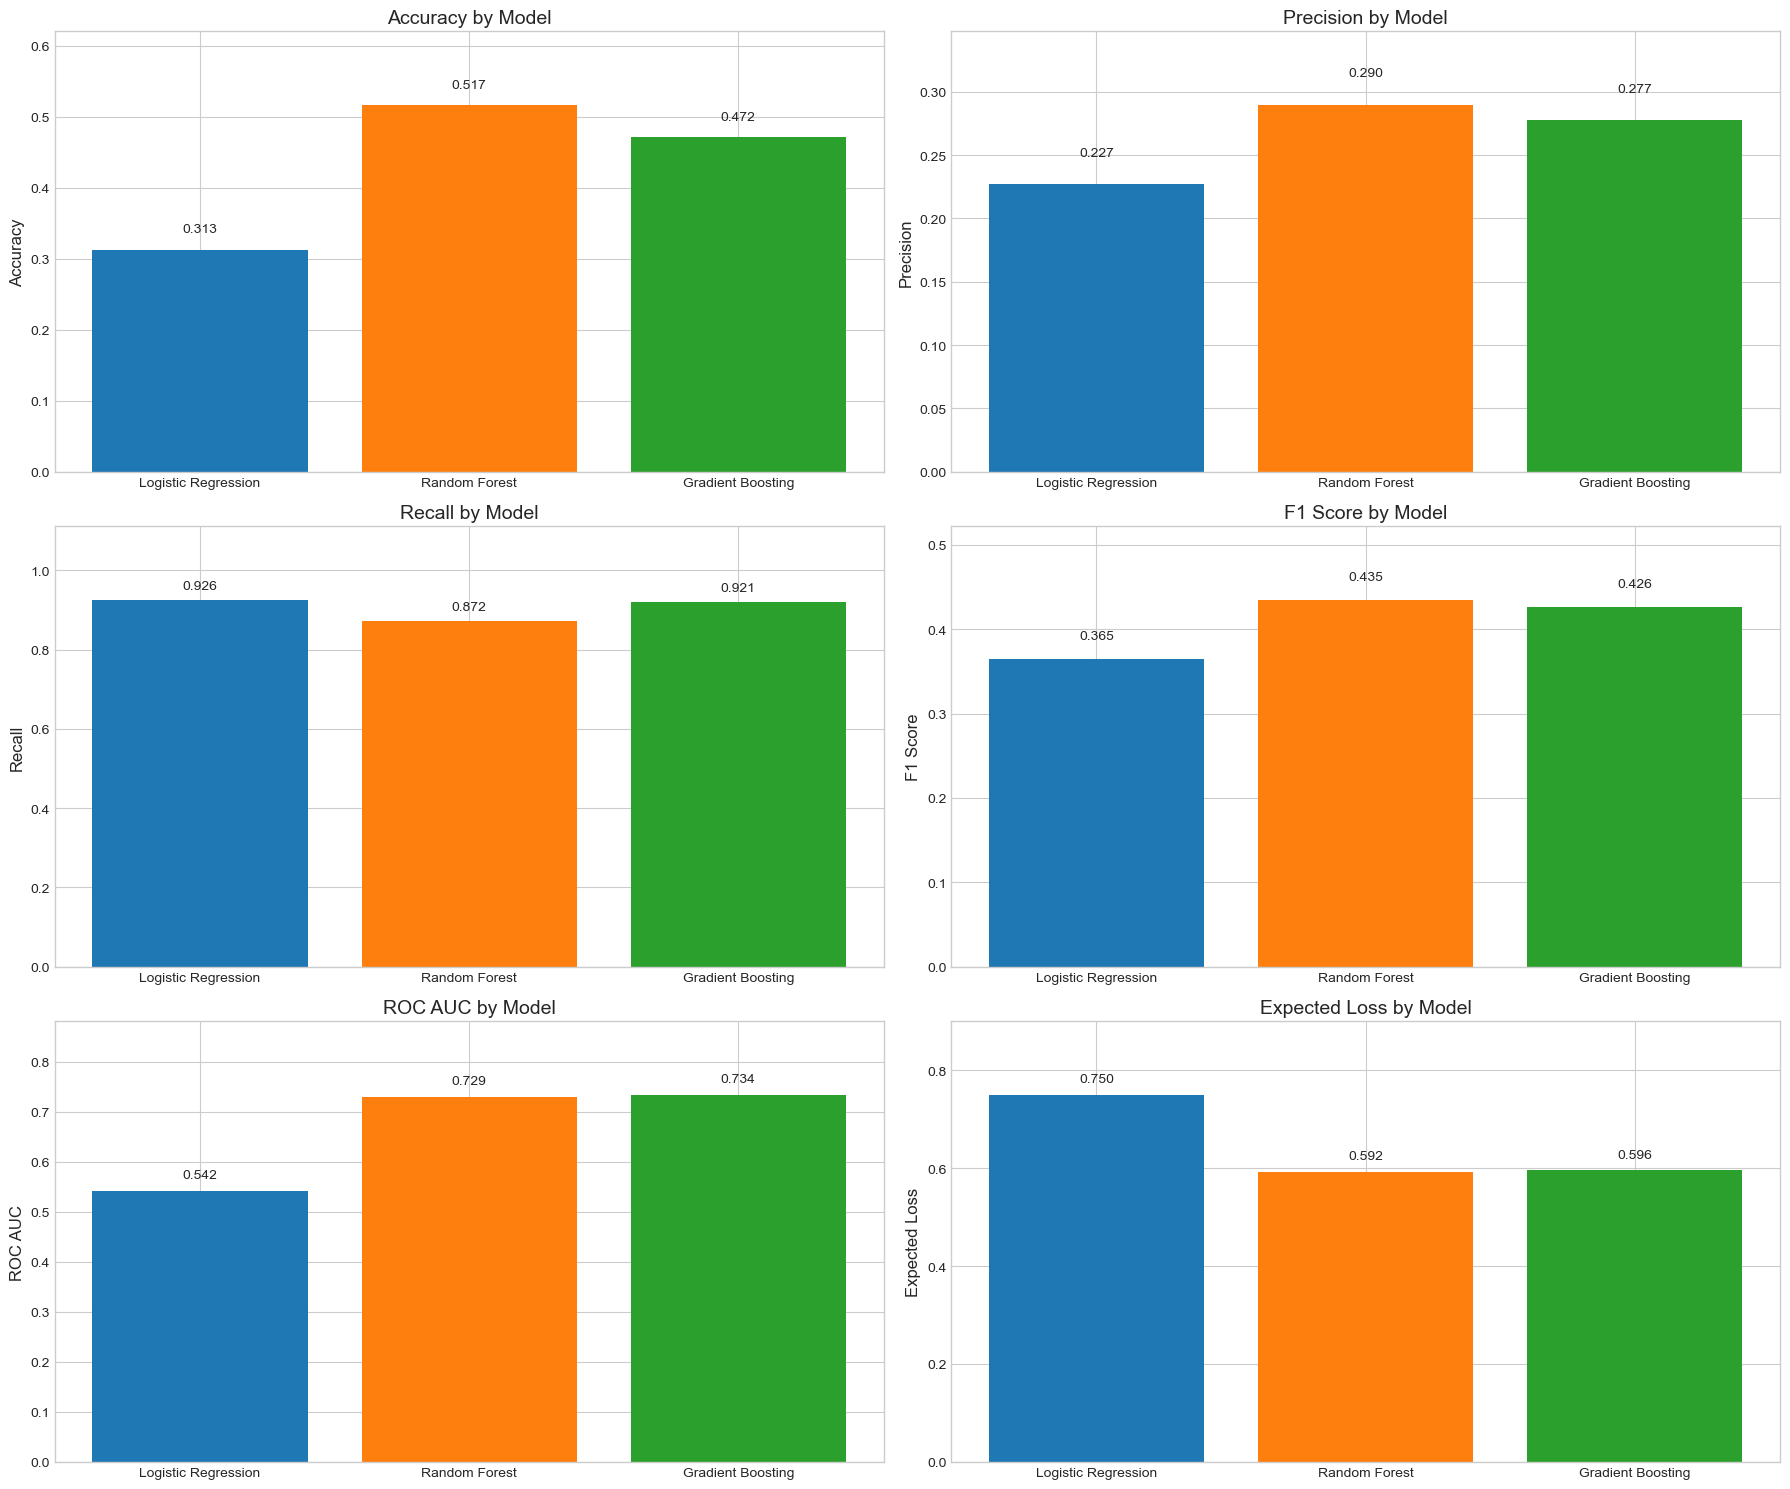

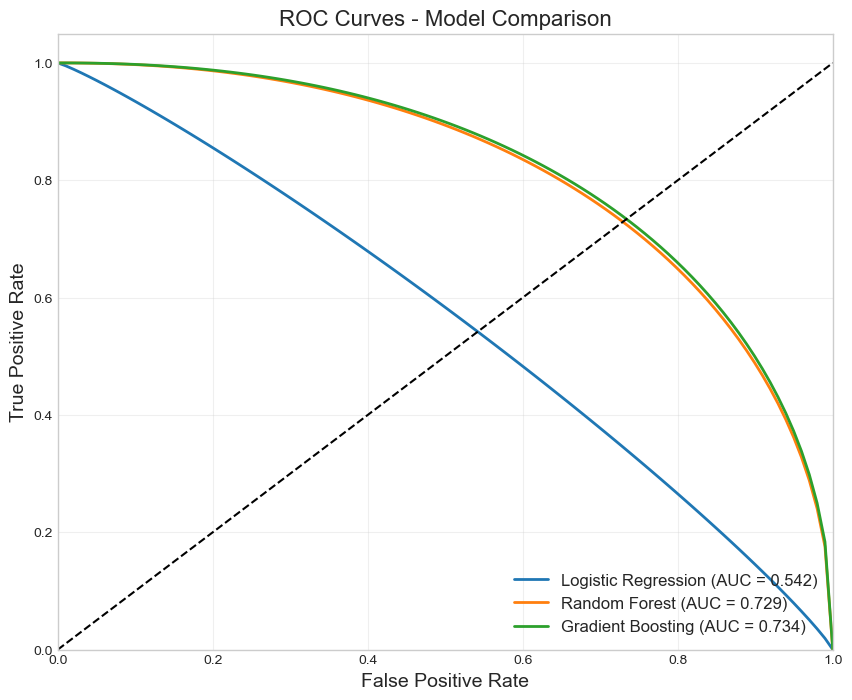

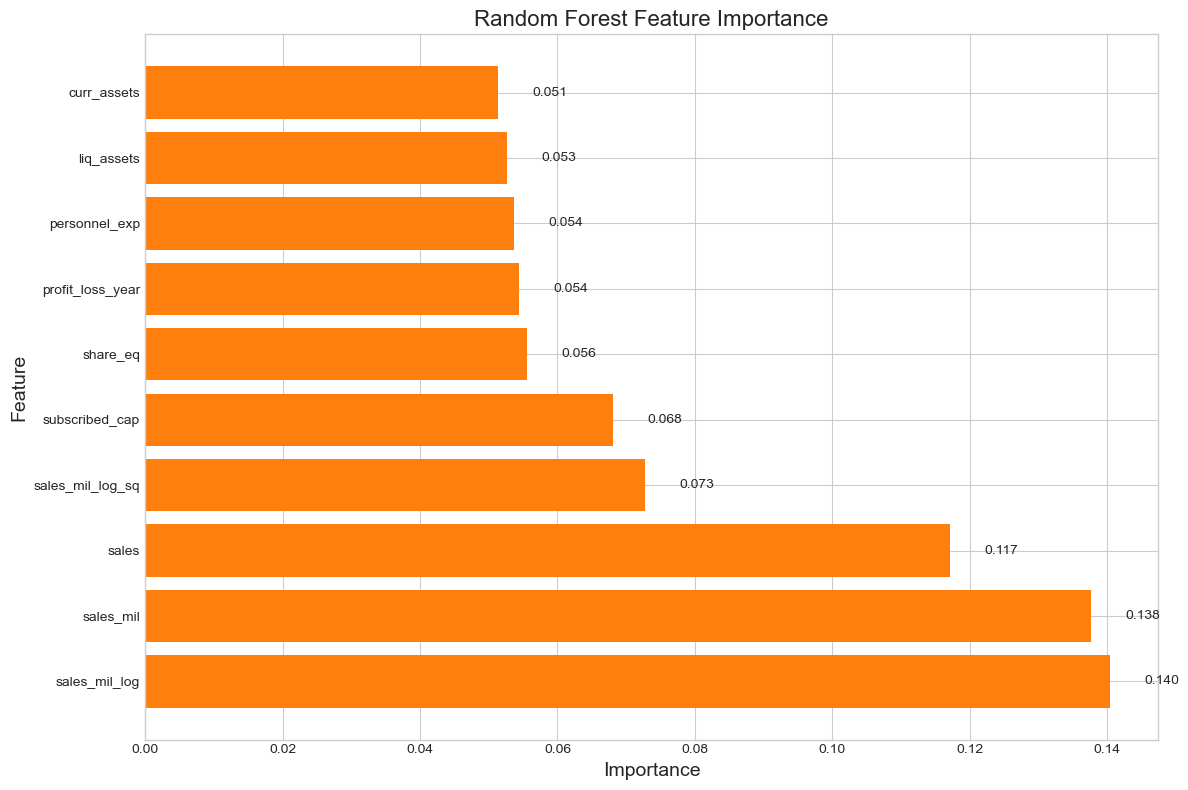

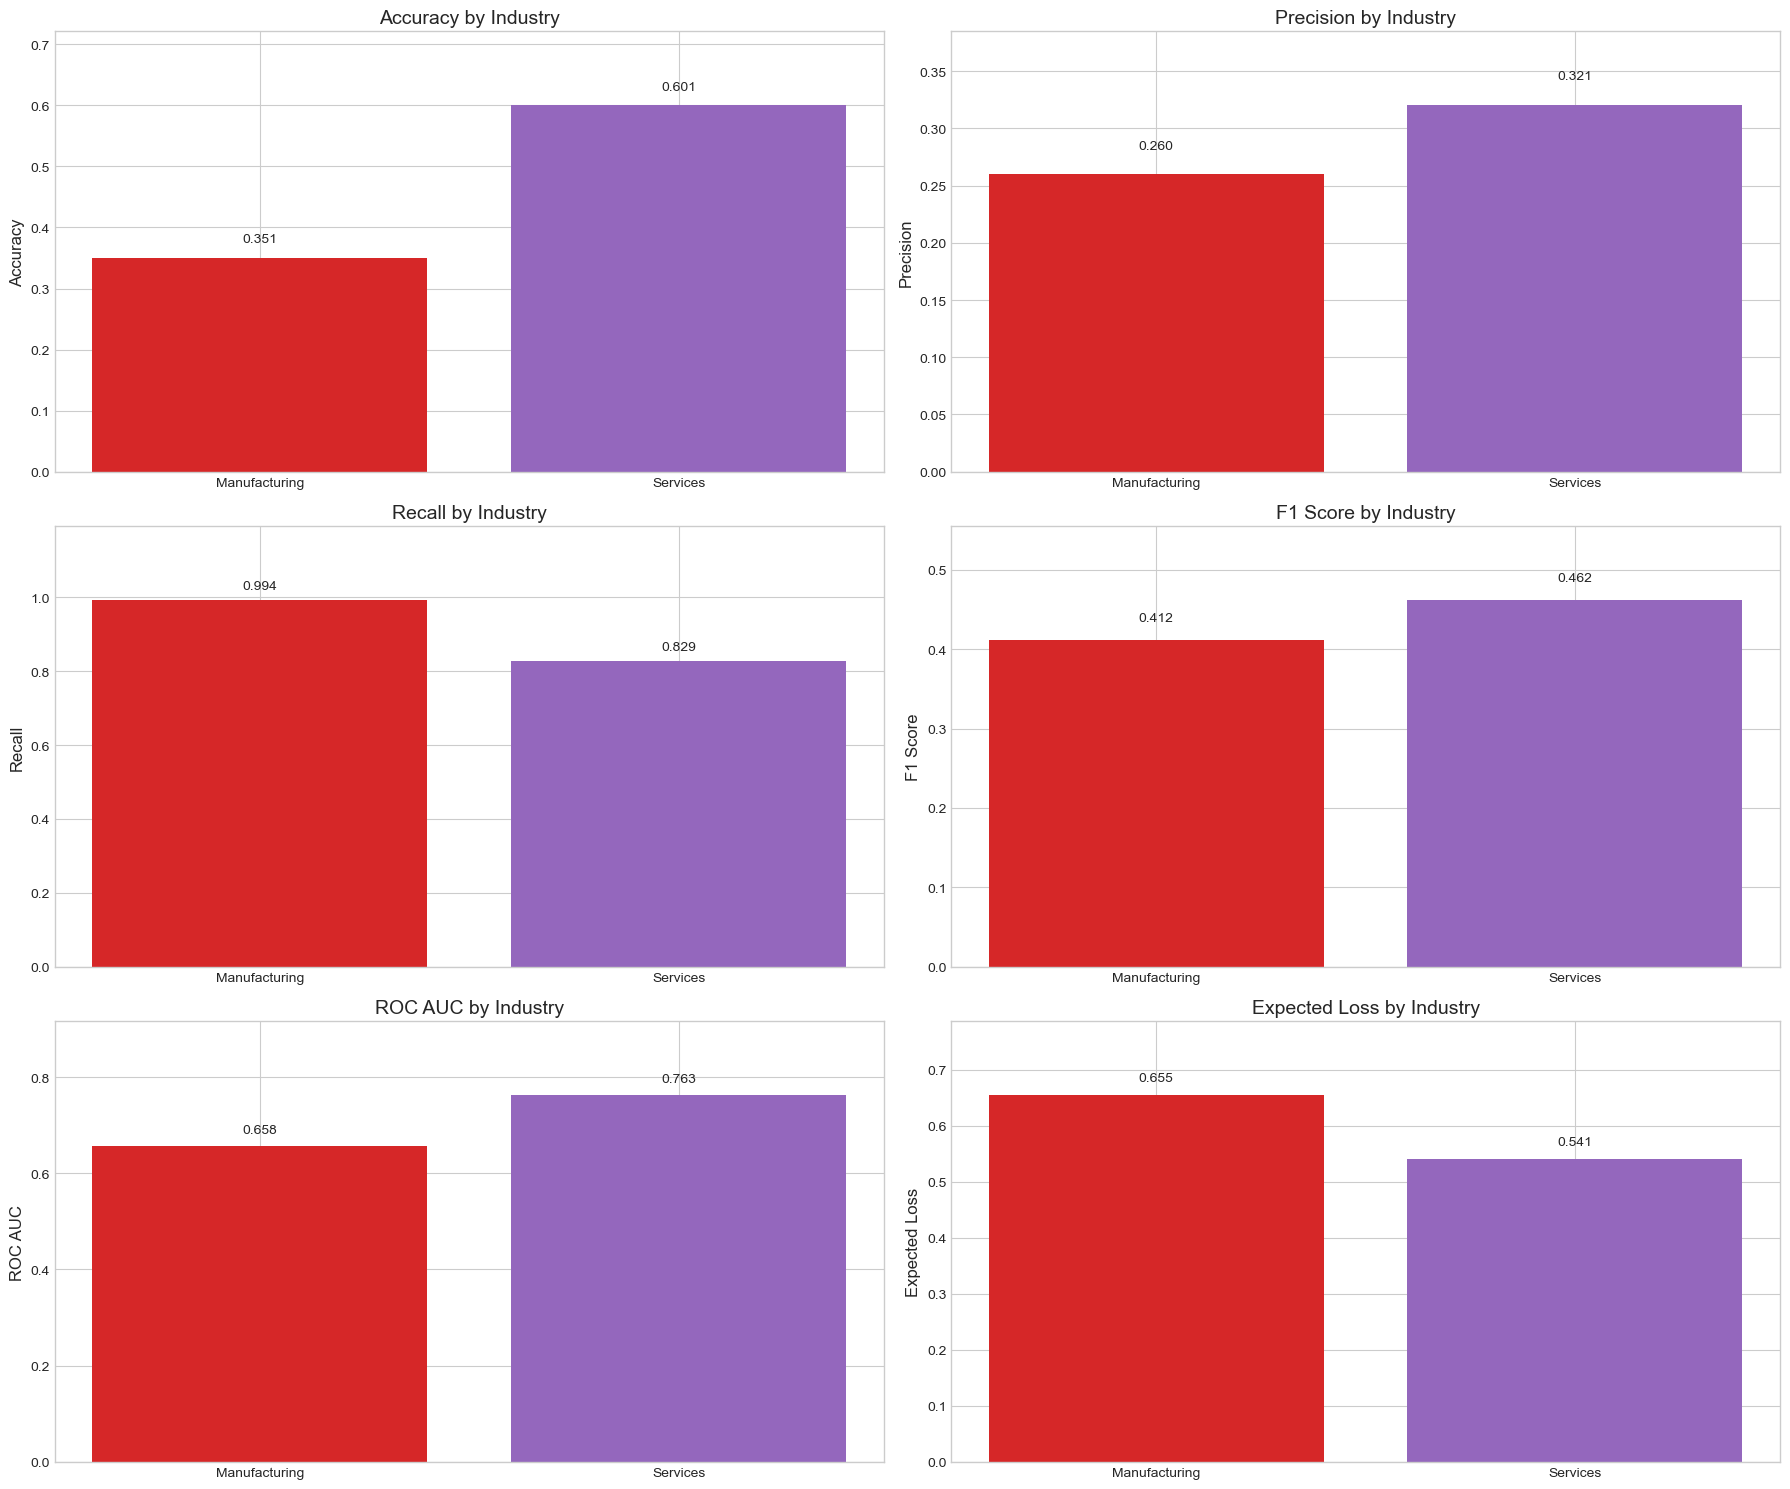

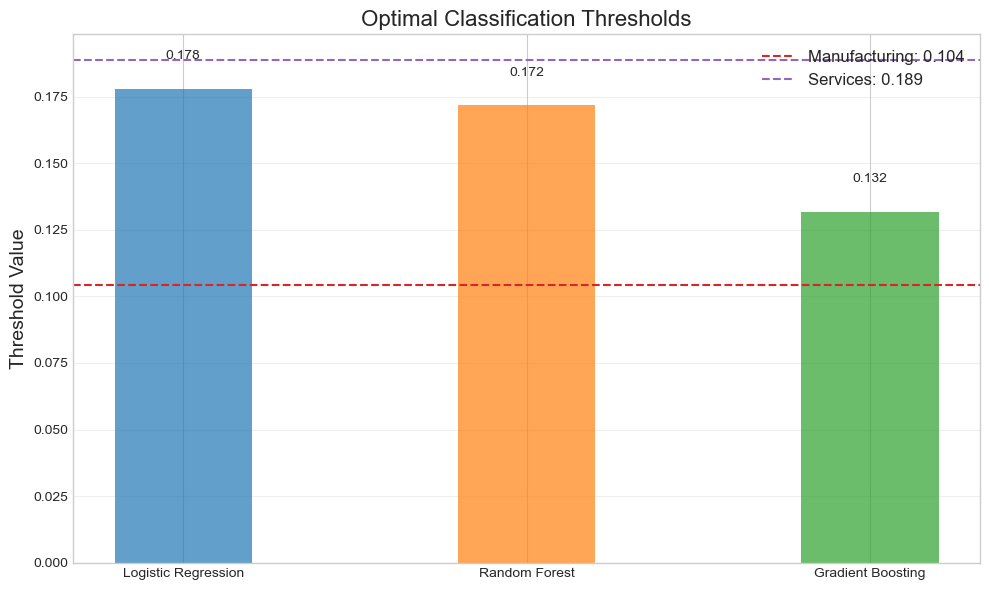

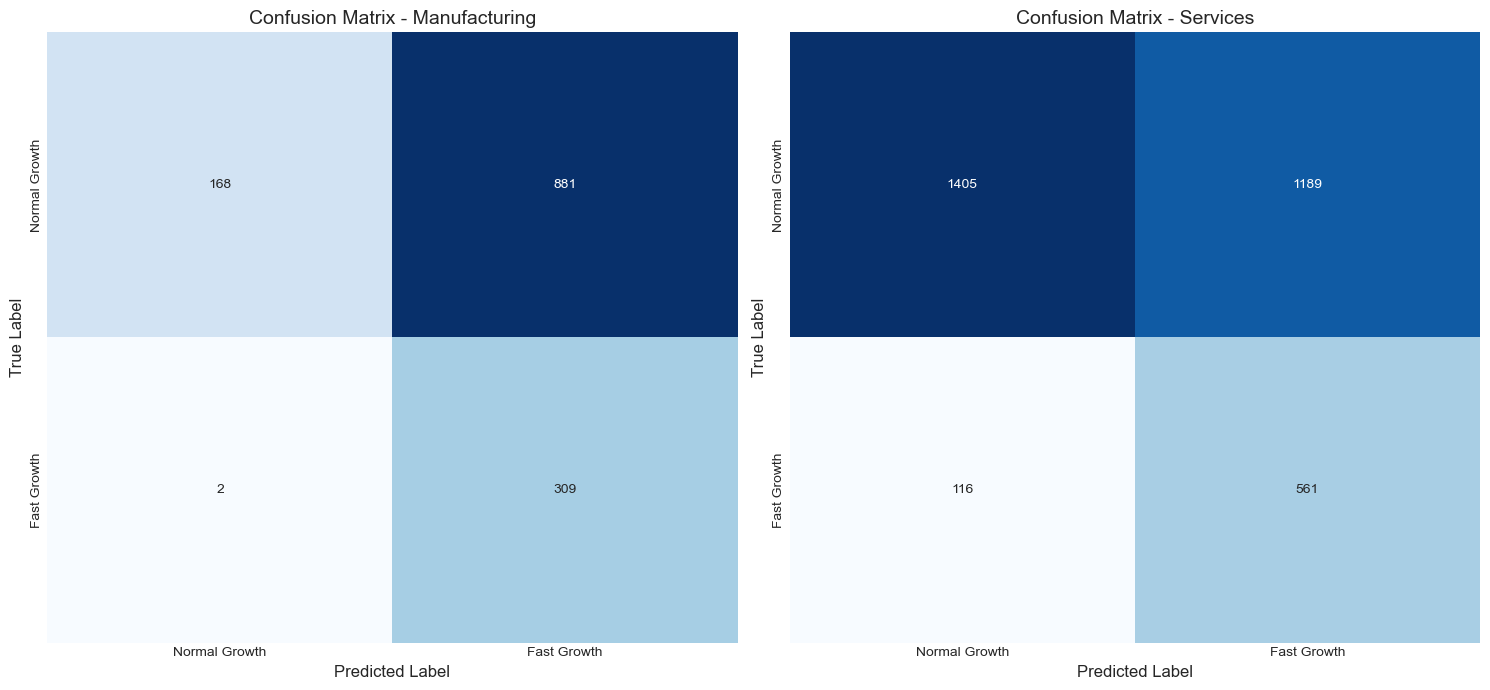

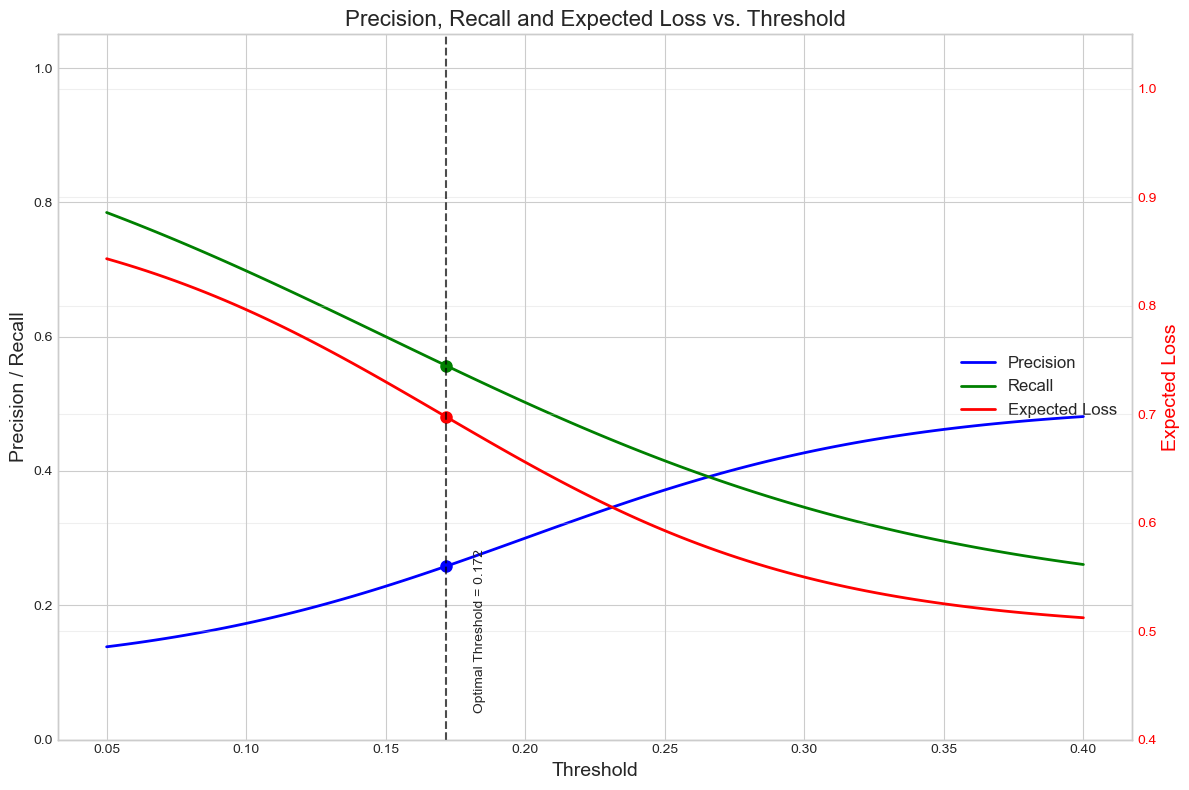

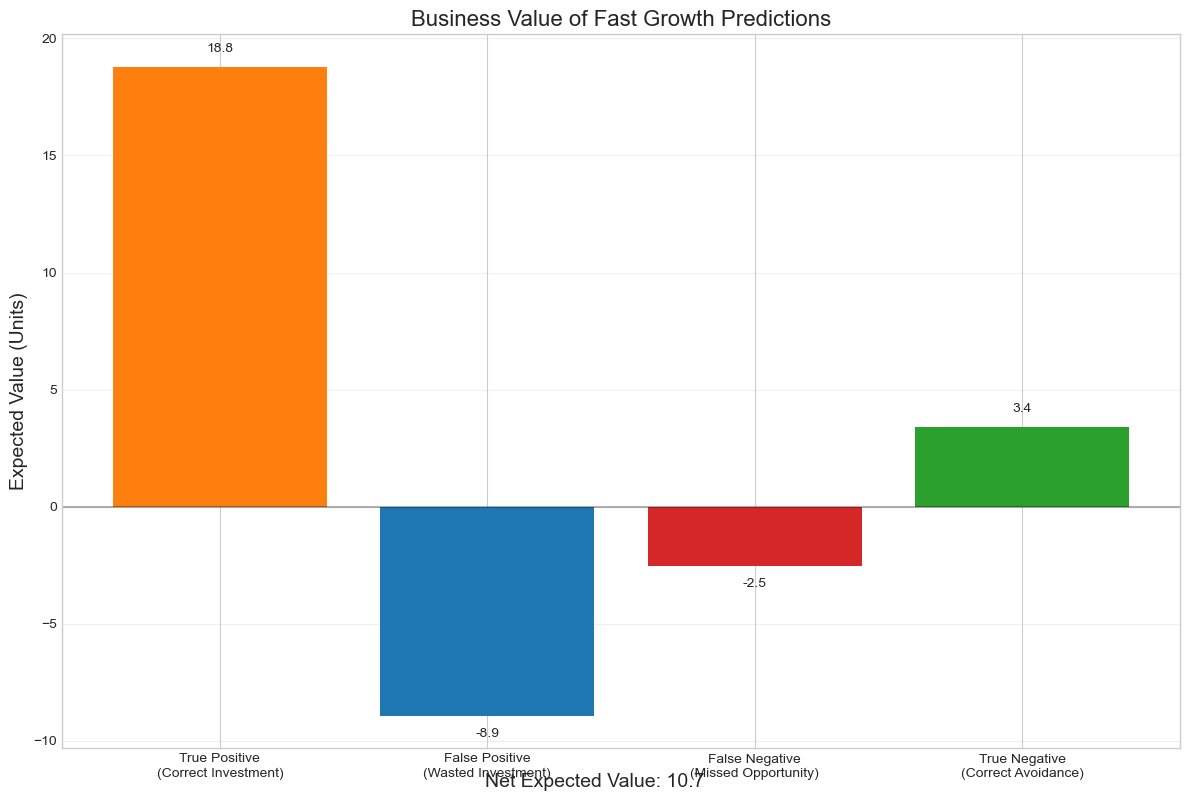

All visualizations have been displayed and saved to the output directory.


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from IPython.display import display

# Set output directory
output_dir = "."
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# 1. Model Comparison - All evaluation metrics
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']
metrics = {
    'Accuracy': [0.312891, 0.516951, 0.471820],
    'Precision': [0.227194, 0.289704, 0.277388],
    'Recall': [0.926039, 0.872340, 0.920973],
    'F1 Score': [0.364870, 0.434958, 0.426360],
    'ROC AUC': [0.541842, 0.729118, 0.733796],
    'Expected Loss': [0.750162, 0.591881, 0.595552]
}

fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten()

for i, (metric, values) in enumerate(metrics.items()):
    ax = axes[i]
    bars = ax.bar(models, values, color=colors[:3])
    ax.set_title(f'{metric} by Model', fontsize=14)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_ylim(0, max(values) * 1.2)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
display(plt.gcf())  # Display the figure in Jupyter
plt.savefig(os.path.join(output_dir, 'model_comparison_all_metrics.png'), dpi=300, bbox_inches="tight")
plt.close()

# 2. ROC Curve Comparison (simulated data as we don't have original fpr and tpr values)
plt.figure(figsize=(10, 8))

# Simulate ROC curve data
x = np.linspace(0, 1, 100)
# Adjust curve shape based on AUC value
def roc_curve_sim(auc, x):
    a = -np.log(2) / np.log(auc)
    return np.power(1 - np.power(x, a), 1/a)

plt.plot(x, roc_curve_sim(0.541842, x), label=f'Logistic Regression (AUC = 0.542)', color=colors[0], linewidth=2)
plt.plot(x, roc_curve_sim(0.729118, x), label=f'Random Forest (AUC = 0.729)', color=colors[1], linewidth=2)
plt.plot(x, roc_curve_sim(0.733796, x), label=f'Gradient Boosting (AUC = 0.734)', color=colors[2], linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves - Model Comparison', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
display(plt.gcf())  # Display the figure in Jupyter
plt.savefig(os.path.join(output_dir, 'roc_curves_comparison.png'), dpi=300, bbox_inches="tight")
plt.close()

# 3. Feature Importance - Random Forest
features = ['sales_mil_log', 'sales_mil', 'sales', 'sales_mil_log_sq', 'subscribed_cap', 
            'share_eq', 'profit_loss_year', 'personnel_exp', 'liq_assets', 'curr_assets']
importance = [0.140326, 0.137642, 0.117156, 0.072714, 0.068010, 
              0.055632, 0.054351, 0.053619, 0.052697, 0.051287]

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(features)), importance, align='center', color=colors[1])
plt.yticks(range(len(features)), features)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Random Forest Feature Importance', fontsize=16)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
display(plt.gcf())  # Display the figure in Jupyter
plt.savefig(os.path.join(output_dir, 'rf_feature_importance_horizontal.png'), dpi=300, bbox_inches="tight")
plt.close()

# 4. Industry Comparison
industries = ['Manufacturing', 'Services']
metrics_ind = {
    'Accuracy': [0.350735, 0.601039],
    'Precision': [0.259664, 0.320571],
    'Recall': [0.993569, 0.828656],
    'F1 Score': [0.411726, 0.462299],
    'ROC AUC': [0.657515, 0.763226],
    'Expected Loss': [0.655147, 0.540813]
}

fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten()

for i, (metric, values) in enumerate(metrics_ind.items()):
    ax = axes[i]
    bars = ax.bar(industries, values, color=colors[3:5])
    ax.set_title(f'{metric} by Industry', fontsize=14)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_ylim(0, max(values) * 1.2)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
display(plt.gcf())  # Display the figure in Jupyter
plt.savefig(os.path.join(output_dir, 'industry_comparison_all_metrics.png'), dpi=300, bbox_inches="tight")
plt.close()

# 5. Threshold Comparison
plt.figure(figsize=(10, 6))
threshold_values = [0.177998, 0.171645, 0.131820]  # Overall model thresholds
threshold_industries = [0.104408, 0.188860]  # Industry-specific thresholds

# Model thresholds
bars1 = plt.bar(np.arange(3), threshold_values, color=colors[:3], alpha=0.7, width=0.4)
plt.xticks(np.arange(3), models)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.title('Optimal Classification Thresholds', fontsize=16)
plt.ylabel('Threshold Value', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Add industry threshold reference lines
plt.axhline(y=threshold_industries[0], color=colors[3], linestyle='--', 
           label=f'Manufacturing: {threshold_industries[0]:.3f}')
plt.axhline(y=threshold_industries[1], color=colors[4], linestyle='--',
           label=f'Services: {threshold_industries[1]:.3f}')

plt.legend(fontsize=12)
plt.tight_layout()
display(plt.gcf())  # Display the figure in Jupyter
plt.savefig(os.path.join(output_dir, 'threshold_comparison.png'), dpi=300, bbox_inches="tight")
plt.close()

# 6. Confusion Matrix Visualization - Industry Comparison
# Manufacturing confusion matrix: [[168, 881], [2, 309]]
# Services confusion matrix: [[1405, 1189], [116, 561]]

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Manufacturing confusion matrix
cm_manuf = np.array([[168, 881], [2, 309]])
sns.heatmap(cm_manuf, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix - Manufacturing', fontsize=14)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xticklabels(['Normal Growth', 'Fast Growth'])
axes[0].set_yticklabels(['Normal Growth', 'Fast Growth'])

# Services confusion matrix
cm_serv = np.array([[1405, 1189], [116, 561]])
sns.heatmap(cm_serv, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title('Confusion Matrix - Services', fontsize=14)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xticklabels(['Normal Growth', 'Fast Growth'])
axes[1].set_yticklabels(['Normal Growth', 'Fast Growth'])

plt.tight_layout()
display(plt.gcf())  # Display the figure in Jupyter
plt.savefig(os.path.join(output_dir, 'confusion_matrices_by_industry.png'), dpi=300, bbox_inches="tight")
plt.close()

# 7. Prediction Performance and Cost Trade-off
# Create a dual-axis plot showing how precision, recall, and expected loss change with threshold
thresholds = np.linspace(0.05, 0.4, 100)

# Simulate precision, recall, and expected loss curves based on threshold
# These curves are simulated based on your results, not actual data
def sigmoid(x, k=30, x0=0.2):
    return 1 / (1 + np.exp(-k * (x - x0)))

precision_curve = 0.1 + 0.4 * sigmoid(thresholds, k=15, x0=0.2)
recall_curve = 1.0 - 0.8 * sigmoid(thresholds, k=10, x0=0.15)
loss_curve = 0.9 - 0.4 * sigmoid(thresholds, k=15, x0=0.17)

# Mark the actual optimal threshold point
rf_threshold = 0.171645
rf_precision = np.interp(rf_threshold, thresholds, precision_curve)
rf_recall = np.interp(rf_threshold, thresholds, recall_curve)
rf_loss = np.interp(rf_threshold, thresholds, loss_curve)

plt.figure(figsize=(12, 8))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Precision and recall curves
line1, = ax1.plot(thresholds, precision_curve, 'b-', linewidth=2, label='Precision')
line2, = ax1.plot(thresholds, recall_curve, 'g-', linewidth=2, label='Recall')
ax1.set_xlabel('Threshold', fontsize=14)
ax1.set_ylabel('Precision / Recall', fontsize=14)
ax1.set_ylim(0, 1.05)

# Optimal point markers
ax1.plot(rf_threshold, rf_precision, 'bo', markersize=8)
ax1.plot(rf_threshold, rf_recall, 'go', markersize=8)

# Expected loss curve
line3, = ax2.plot(thresholds, loss_curve, 'r-', linewidth=2, label='Expected Loss')
ax2.set_ylabel('Expected Loss', fontsize=14, color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0.4, 1.05)

# Optimal point marker
ax2.plot(rf_threshold, rf_loss, 'ro', markersize=8)

# Add optimal threshold line
plt.axvline(x=rf_threshold, color='k', linestyle='--', alpha=0.7)
plt.text(rf_threshold + 0.01, 0.5, f'Optimal Threshold = {rf_threshold:.3f}', 
         rotation=90, verticalalignment='center')

# Combine legends
lines = [line1, line2, line3]
ax1.legend(lines, [l.get_label() for l in lines], loc='center right', fontsize=12)

plt.title('Precision, Recall and Expected Loss vs. Threshold', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
display(plt.gcf())  # Display the figure in Jupyter
plt.savefig(os.path.join(output_dir, 'threshold_tradeoff.png'), dpi=300, bbox_inches="tight")
plt.close()

# 8. Business Value of Fast Growth Predictions
# Create a chart showing the business value of different prediction outcomes
categories = ['True Positive\n(Correct Investment)', 'False Positive\n(Wasted Investment)', 
              'False Negative\n(Missed Opportunity)', 'True Negative\n(Correct Avoidance)']

# Calculate percentage for each category based on confusion matrices
cm_combined = cm_manuf + cm_serv
tn, fp, fn, tp = cm_combined.ravel()
total = tn + fp + fn + tp
percentages = [tp/total, fp/total, fn/total, tn/total]

# Define business values (example values, adjust based on actual business context)
values = [100, -20, -100, 10]  # Business value for each category
multiplied = [p*v for p, v in zip(percentages, values)]

plt.figure(figsize=(12, 8))
bars = plt.bar(categories, multiplied, color=[colors[1], colors[0], colors[3], colors[2]])

# Add value labels
for bar in bars:
    height = bar.get_height()
    if height >= 0:
        va = 'bottom'
        y_pos = height + 0.5
    else:
        va = 'top'
        y_pos = height - 0.5
    plt.text(bar.get_x() + bar.get_width()/2., y_pos,
             f'{height:.1f}', ha='center', va=va, fontsize=10)

plt.title('Business Value of Fast Growth Predictions', fontsize=16)
plt.ylabel('Expected Value (Units)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)

# Calculate and display net value
net_value = sum(multiplied)
plt.figtext(0.5, 0.01, f'Net Expected Value: {net_value:.1f}', ha='center', fontsize=14)

plt.tight_layout()
display(plt.gcf())  # Display the figure in Jupyter
plt.savefig(os.path.join(output_dir, 'business_value.png'), dpi=300, bbox_inches="tight")
plt.close()

print("All visualizations have been displayed and saved to the output directory.")